In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"

In [2]:
# disable the annoying noise with red background color
import logging
logging.disable(logging.INFO)
logging.disable(logging.WARNING)

In [3]:
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import BertTokenizer,AutoTokenizer, BertConfig, Trainer
from transformers import EvalPrediction
from transformers import TrainingArguments

from tokenizers.pre_tokenizers import BertPreTokenizer
from tokenizers.pre_tokenizers import Digits
from tokenizers.pre_tokenizers import Sequence
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.pre_tokenizers import Split
from tokenizers import Regex

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
 
from sklearn.metrics import precision_recall_curve, roc_curve
import pandas as pd
import numpy as np
import json
import re
import tqdm

In [4]:
assert torch.cuda.is_available()

In [5]:
from ensemble_embedding import ProteinLigandAffinity

In [6]:
# estimate errors using dropout layers

from contextlib import contextmanager
from types import MethodType
from functools import partial

@contextmanager
def dropout(module: torch.nn.Module, p = None):

    def apply_dropout(m):
        if m.__class__.__name__.startswith('Dropout'):
            m.train()
            if p is not None:
                m.p = p
                
    def my_train(self, train = True):
        old_train(train)
        if not train:
            # evaluation mode
            self.apply(apply_dropout)
        return self

    # Code to acquire resource, e.g.:
    old_train = module.train
    module.train =  MethodType(my_train, module)
    try:
        yield module
    finally:
        # Code to release resource, e.g.:
        module.train = old_train

**Load tokenizers and submodels**

In [7]:
#model_name = "Rostlab/prot_t5_xl_uniref50" # for embedding only
seq_model_name = "Rostlab/prot_bert_bfd" # for fine-tuning

In [8]:
seq_tokenizer = BertTokenizer.from_pretrained(seq_model_name, do_lower_case=False)

In [9]:
# set up tokenizer and pre-trained model
model_base_directory_dict = {
    "bert": ["/home/xvg/affinity_pred/train/tokenizer_bert",
            "/home/xvg/affinity_pred/train/bert_smiles_bert",
            "/home/xvg/affinity_pred/train/ensemble_bert_mse"],
    "regex": ["/home/xvg/affinity_pred/train/tokenizer_regex",
              "/home/xvg/affinity_pred/train/bert_smiles_regex",
              "/home/xvg/affinity_pred/train/ensemble_regex_mse"]
}

def setup_tokenizer(tokenizer_type):
    global model_files, smiles_tokenizer
    global model_base_directory_dict
    global n_cross_attention, eval_batch_size

    smiles_tokenizer_directory = model_base_directory_dict[tokenizer_type][0]+'/tokenizer'
    smiles_model_directory = model_base_directory_dict[tokenizer_type][1]
    ensemble_model_prefix = model_base_directory_dict[tokenizer_type][2]
    
    ckpt = ''
    ensemble_model_prefix, n_cross_attention, eval_batch_size = "/home/xvg/affinity_pred/train/results_crusher_seq_bert_attn_bert_bs12288_regex_1cross_lr3e-5_no_kras_seqlen2048_fp16_False_scheduler_constant_with_warmup_", 1, 8
    ensemble_model_prefix, n_cross_attention, eval_batch_size,ckpt = "/home/xvg/affinity_pred/train/results_crusher_seq_bert_attn_bert_bs12288_regex_3cross_lr3e-5_no_kras_seqlen2048_fp16_False_scheduler_constant_with_warmup_", 3, 16, 'checkpoint-5400'
    ensemble_model_prefix, n_cross_attention, eval_batch_size,ckpt = "/home/xvg/affinity_pred/train/results_crusher_sentencepair_seq_bert_attn_bert_bs12288_regex_3cross_lr3e-5_no_kras_seqlen2048_fp16_False_scheduler_constant_with_warmup_", 3, 16, 'checkpoint-3300'
    ensemble_model_prefix, n_cross_attention, eval_batch_size,ckpt = "/home/xvg/affinity_pred/train/results_crusher_git_ad367b66_seq_bert_attn_bert_bs12288_regex_10cross_lr3e-5_no_kras_seqlen2048_fp16_False_scheduler_constant_with_warmup_", 10, 16, 'checkpoint-1700'
    ensemble_model_prefix, n_cross_attention, eval_batch_size,ckpt = "/netdisk/xvg/results_crusher_git_0162627ec_seq_bert_attn_bert_bs12288_regex_12cross_lr3e-5_no_kras_seqlen2048_fp16_False_scheduler_constant_with_warmup_", 12, 16, 'checkpoint-4400'
    ensemble_model_prefix, n_cross_attention, eval_batch_size,ckpt = "/netdisk/xvg/results_crusher_git_6b5b92cf7_seq_bert_attn_bert_bs12288_regex_12cross_lr3e-5_no_kras_seqlen2048_fp16_False_scheduler_constant_with_warmup_", 12, 16, 'checkpoint-1900'
    
    tokenizer_config = json.load(open(smiles_tokenizer_directory+'/config.json','r'))

    smiles_tokenizer =  AutoTokenizer.from_pretrained(smiles_tokenizer_directory, **tokenizer_config)

    if tokenizer_type == 'regex':
        smiles_tokenizer.backend_tokenizer.pre_tokenizer = Sequence([WhitespaceSplit(),
            Split(Regex(r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""), behavior='isolated')])

    print('Tokenizer lower_case:', smiles_tokenizer.do_lower_case, flush=True)

    import glob
    model_files = list(glob.glob(ensemble_model_prefix+'*'))
    model_files = [m + "/"+ckpt+"/"+"pytorch_model.bin" for m in model_files]
    return smiles_model_directory

In [10]:
def expand_seqs(seqs):
    input_fixed = ["".join(seq.split()) for seq in seqs]
    input_fixed = [re.sub(r"[UZOB]", "X", seq) for seq in input_fixed]
    return [list(seq) for seq in input_fixed]

In [11]:
# on-the-fly tokenization
from rdkit import Chem
def encode(item, padding='max_length'):
        seq_encodings = seq_tokenizer(expand_seqs(item['seq'])[0],
                                 is_split_into_words=True,
                                 return_offsets_mapping=False,
                                 truncation=True,
                                 padding=padding,
                                 add_special_tokens=True,
                                 max_length=max_seq_length)

        item['input_ids_1'] = [torch.tensor(seq_encodings['input_ids'])]
        item['attention_mask_1'] = [torch.tensor(seq_encodings['attention_mask'])]

        smiles_encodings = smiles_tokenizer(item['smiles_can'][0],
                                            padding=padding,
                                            max_length=max_smiles_length,
                                            add_special_tokens=True,
                                            truncation=True)

        item['input_ids_2'] = [torch.tensor(smiles_encodings['input_ids'])]
        item['attention_mask_2'] = [torch.tensor(smiles_encodings['attention_mask'])]

        return item

**Load model**

In [12]:
max_smiles_length = 200
max_seq_length = 2048

In [13]:
def model_init():
    global n_cross_attention, max_seq_length
    smiles_model_directory = setup_tokenizer('regex')
    model = ProteinLigandAffinity(seq_model_name, smiles_model_directory,
#                                n_cross_attention_layers=n_cross_attention)
                                  n_layers=n_cross_attention)
                                  
    return model

In [14]:
def compute_metrics(p: EvalPrediction):
    preds_list, out_label_list = p.predictions, p.label_ids

    return {
        "mse": mean_squared_error(out_label_list, preds_list),
        "mae": mean_absolute_error(out_label_list, preds_list),
    }

In [15]:
def load_ensemble(ensemble_id, tokenizer_type='regex'):
    global trainer
    global batch_size
    setup_tokenizer(tokenizer_type)
    
    # the trainer needs to be re-initialized if the number of cross attention layers changes
    trainer = Trainer(
        model_init=model_init,                # the instantiated 🤗 Transformers model to be trained
        compute_metrics = compute_metrics,    # evaluation metric
        args=TrainingArguments(per_device_eval_batch_size=eval_batch_size,
                               output_dir='results'
                              )
#                               fp16_full_eval=True)
    )

    checkpoint = torch.load(model_files[ensemble_id])
    trainer.model.load_state_dict(checkpoint,strict=True)

In [16]:
# un-normalize predictions [to -log_10 affinity[M] units]
#mean, var = (6.49685099, 2.43570803)
#mean, var = (6.86202031, 2.57502859)

import json
scaler_dict = json.load(open('/home/xvg/binding_affinity/data/scaling.json'))
mean,var = scaler_dict['mean_'], scaler_dict['var_']

def scale(x):
    return x*np.sqrt(var)+mean
def scale_var(x):
    return x*var

In [17]:
mpro_seq_5r84 = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ"
mpro_seq_uniprot = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCSGVTFQ"

In [18]:
load_ensemble(0)
pytorch_total_params = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
pytorch_seq_params =  sum(p.numel() for p in trainer.model.seq_model.parameters() if p.requires_grad)
pytorch_smiles_params =  sum(p.numel() for p in trainer.model.smiles_model.parameters() if p.requires_grad)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [19]:
pytorch_smiles_params

108490752

In [20]:
pytorch_total_params

722378753

In [21]:
class InhibDataset(Dataset):
    def __init__(self, df, seq, smiles_name='smiles', padding='max_length'):
        self.df = df
        self.seq = seq
        self.smiles_name = smiles_name
        self.padding = padding
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        item = {'seq': [self.seq]}
        
        try:
            # make canonical
            item['smiles_can'] = [str(Chem.MolToSmiles(Chem.MolFromSmiles(row[self.smiles_name])))]
        except:
            item['smiles_can'] = [str(row[self.smiles_name])]
        
        item = encode(item, padding = self.padding)
        
        # get first (single) item
        item['input_ids_1'] = item['input_ids_1'][0]
        item['attention_mask_1'] = item['attention_mask_1'][0]

        item['input_ids_2'] = item['input_ids_2'][0]
        item['attention_mask_2'] = item['attention_mask_2'][0]

        # drop the encoder input
        item.pop('smiles_can')
        item.pop('seq')
        return item

    def __len__(self):
        return len(self.df)

In [22]:
from rdkit import Chem
class ProteinDataset(Dataset):
    def __init__(self, df, smiles, seq_name='seq'):
        self.df = df

        try:
            # make canonical
            self.smiles_can = str(Chem.MolToSmiles(Chem.MolFromSmiles(smiles)))
        except:
            self.smiles_can = str(smiles)
 
        self.seq_name = seq_name
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        item = {'smiles_can': [self.smiles_can]}
        
        # make canonical
        item['seq'] = [row[self.seq_name].upper()]
        
        item = encode(item)
        
        # get first (single) item
        item['input_ids_1'] = item['input_ids_1'][0]
        item['attention_mask_1'] = item['attention_mask_1'][0]

        item['input_ids_2'] = item['input_ids_2'][0]
        item['attention_mask_2'] = item['attention_mask_2'][0]

        # drop the encoder input
        item.pop('smiles_can')
        item.pop('seq')
        return item

    def __len__(self):
        return len(self.df)

**Viral proteins**

In [23]:
from Bio import SeqIO

with open('/home/xvg/protein.faa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seq = []
    desc = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        seq.append(str(seq_record.seq))
        desc.append(seq_record.description)

df_virus = pd.DataFrame({'id': identifiers, 'seq': seq, 'description': desc})

**RDRP live virus**

In [163]:
rdrp_seq = df_virus[df_virus['description'].str.contains('RNA-dependent RNA polymerase')]['seq'].values[0]

In [164]:
# uniprot
plpro_seq = 'SMTYGQQFGPTYLDGADVTKIKPHVNHEGKTFFVLPSDDTLRSEAFEYYHTLDESFLGRYMSALNHTKKWKFPQVGGLTSIKWADNNCYLSSVLLALQQLEVKFNAPALQEAYYRARAGDAANFCALILAYSNKTVGELGDVRETMTHLLQHANLESAKRVLNVVCKHCGQKTTTLTGVEAVMYMGTLSYDNLKTGVSIPCVCGRDATQYLVQQESSFVMMSAPPAEYKLQQGTFLCANEYTGNYQCGHYTHITAKETLYRIDGAHLTKMSEYKGPVTDVFYKETSYTTTIKPVSYKLDGVTYTEIEPKLDGYYK'

In [165]:
nsp15_seq = df_virus[df_virus['description'].str.contains('endo')].seq.values[0]

In [166]:
df = pd.read_csv('/home/xvg/live_virus.csv')
#df = df[df['Target']=='rdrp'].copy().reset_index(drop=True)
#df = df[(df['Target']=='plpro_7JIR') & (df['max-response'] > 25)].copy().reset_index(drop=True)
#df = df[(df['Target']=='rdrp') & (df['max-response'] > 5) & (df['ec50'] > -7)].copy().reset_index(drop=True)
#df = df[(df['Target'].str.startswith('mpro')) & (df['max-response'] > 15) & (df['ec50'] > -7)].copy().reset_index(drop=True)

In [167]:
rdrp_virus_dataset = InhibDataset(df,seq=rdrp_seq, smiles_name='Smiles')
plpro_virus_dataset = InhibDataset(df,seq=plpro_seq, smiles_name='Smiles')
mpro_virus_dataset = InhibDataset(df,seq=mpro_seq_5r84, smiles_name='Smiles')
nsp15_virus_dataset = InhibDataset(df,seq=nsp15_seq,smiles_name='Smiles')

In [168]:
y_pred=trainer.predict(rdrp_virus_dataset)
df['affinity_mean_rdrp'] = scale(y_pred.predictions[:,0])
y_pred=trainer.predict(plpro_virus_dataset)
df['affinity_mean_plpro'] = scale(y_pred.predictions[:,0])
y_pred=trainer.predict(mpro_virus_dataset)
df['affinity_mean_mpro'] = scale(y_pred.predictions[:,0])
y_pred=trainer.predict(nsp15_virus_dataset)
df['affinity_mean_nsp15'] = scale(y_pred.predictions[:,0])

In [171]:
from scipy.stats import spearmanr
column_name = 'ec50'
filt = (~df[column_name].isna()) & (df['ec50'] > -9)
x = df[filt]['affinity_mean_rdrp']
y = df[filt][column_name]
print('RDRP ',spearmanr(x,y))
x = df[filt]['affinity_mean_plpro']
y = df[filt][column_name]
print('PLpro ',spearmanr(x,y))
x = df[filt]['affinity_mean_mpro']
y = df[filt][column_name]
print('Mpro ',spearmanr(x,y))

RDRP  SpearmanrResult(correlation=-0.0842698930751478, pvalue=0.34046762758724214)
PLpro  SpearmanrResult(correlation=0.06338745578937306, pvalue=0.473701861806497)
Mpro  SpearmanrResult(correlation=-0.14557893730625845, pvalue=0.09840401764116403)


In [172]:
targets = df.simple_target.unique()

In [173]:
[(df['simple_target']==t).sum() for t in targets]

[69, 31, 54, 7]

<AxesSubplot:>

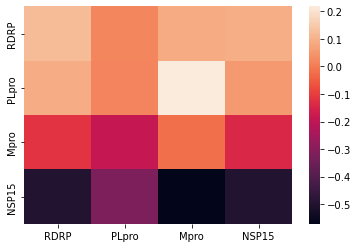

In [174]:
from scipy.stats import spearmanr
import seaborn as sn
column_name = 'ec50'

m = np.zeros((len(targets),len(targets)),dtype=np.float32)
for i,ti in enumerate(targets):
    for j,tj in enumerate(targets):
        filt = df['simple_target']==ti
        x = df[filt]['affinity_mean_{}'.format(tj.lower())]
        y = -df[filt][column_name]
        s = spearmanr(x,y).correlation
        m[i,j] = s

import seaborn as sn
df_cm = pd.DataFrame(m, index = targets, columns = targets)
sn.heatmap(df_cm)

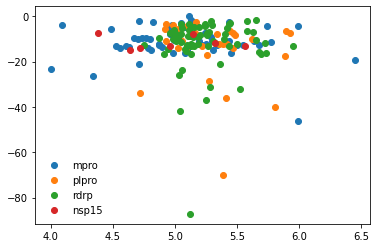

In [121]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

column_name = 'max-response'
filt = df['simple_target'] == 'Mpro'
y = -df[filt][column_name] 
x = df[filt]['affinity_mean_mpro']
ax.scatter(x,y,label='mpro')

filt = df['simple_target'] == 'PLpro'
y = -df[filt][column_name] 
x = df[filt]['affinity_mean_plpro']
ax.scatter(x,y,label='plpro')

filt = df['simple_target'] == 'RDRP'
y = -df[filt][column_name] 
x = df[filt]['affinity_mean_rdrp']
ax.scatter(x,y,label='rdrp')

filt = df['simple_target'] == 'NSP15'
y = -df[filt][column_name] 
x = df[filt]['affinity_mean_nsp15']
ax.scatter(x,y,label='nsp15')

ax.legend(frameon=False)

**Human TMPRS22**

In [35]:
from Bio import SeqIO
tmprss2_seq = str(next(SeqIO.parse('/home/xvg/tmprss2.fasta','fasta')).seq)

In [36]:
len(tmprss2_seq)

492

In [37]:
df = pd.read_csv('/home/xvg/tmprss.csv',skiprows=1)#.drop(labels=0).reset_index(drop=True)

In [38]:
tmprss2_dataset = InhibDataset(df,tmprss2_seq,'SMILES')

In [39]:
y_pred=trainer.predict(tmprss2_dataset)
df['affinity_mean'] = scale(y_pred.predictions[:,0])
#df['affinity_var'] = scale_var(y_pred.predictions[:,1])

***** Running Prediction *****
  Num examples = 2560
  Batch size = 64
RDKit ERROR: [18:41:51] SMILES Parse Error: syntax error while parsing: CCP(|[Au]SC1OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C1OC(C)=O)(CC)CC
RDKit ERROR: [18:41:51] SMILES Parse Error: Failed parsing SMILES 'CCP(|[Au]SC1OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C1OC(C)=O)(CC)CC' for input: 'CCP(|[Au]SC1OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C1OC(C)=O)(CC)CC'
RDKit ERROR: [18:42:11] SMILES Parse Error: syntax error while parsing: CC1C(OC2(CC1)CC3CC(C/C=C(C)/CC(C)\C=C\C=C\4COC5/C(=N/O)C(=CC(C(=O)O3)C45O)C)O2)[R]
RDKit ERROR: [18:42:11] SMILES Parse Error: Failed parsing SMILES 'CC1C(OC2(CC1)CC3CC(C/C=C(C)/CC(C)\C=C\C=C\4COC5/C(=N/O)C(=CC(C(=O)O3)C45O)C)O2)[R]' for input: 'CC1C(OC2(CC1)CC3CC(C/C=C(C)/CC(C)\C=C\C=C\4COC5/C(=N/O)C(=CC(C(=O)O3)C45O)C)O2)[R]'
RDKit ERROR: [18:42:23] SMILES Parse Error: syntax error while parsing: CC(C)C1(NC(=O)C2CC3C(CC4=C[NH]C5=CC=CC3=C45)N(C)C2)OC6(O)C7CCCN7C(=O)C(N6C1=O)[R].C[S](O)(=O)=O
RDKit ERROR: [18:42:23]

In [40]:
len(df)

2560

In [42]:
#column_name = 'Luminescence (Normalized)'
column_name = 'Luminescence (Normalized).1'

from scipy.stats import spearmanr
x = df[~df[column_name].isna()]['affinity_mean']
y = df[~df[column_name].isna()][column_name]
spearmanr(x,y)

SpearmanrResult(correlation=-0.07658325331480881, pvalue=0.00010504002074442045)

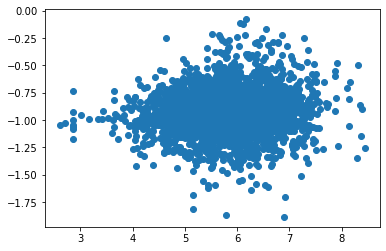

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
filt = (~df[column_name].isna())

y = -df[filt][column_name] 
x = df[filt]['affinity_mean']
ax.scatter(x,y,label='mpro')

**NSP3 macrodomain**

In [82]:
nsp3_mac1_seq = df_virus.iloc[13]['seq']

In [83]:
nsp3_mac1_seq = 'MHHHHHHENLYFQSNAGEVNSFSGYLKLTDNVYIKNADIVEEAKKVKPTVVVNAANVYLKHGGGVAGALNKATNNAMQVESDDYIATNGPLKVGGSCVLSGHNLAKHCLHVVGPNVNKGEDIQLLKSAYENFNQHEVLLAPLLSAGIFGADPIHSLRVCVDTVRTNVYLAVFDKNLYDKLVSSFLE'
nsp3_mac1_seq = nsp3_mac1_seq[7:]

In [84]:
len(nsp3_mac1_seq)

179

In [85]:
df = pd.read_csv('/home/xvg/nsp3_macrodomain.csv',skiprows=1).drop(labels=0).reset_index(drop=True)
df = df[~df.SMILES.isna()].copy()
#df = df[df['Significantly different (p < 0.05)']=='*'].copy().reset_index(drop=True)

In [86]:
nsp3_mac1_dataset = InhibDataset(df,nsp3_mac1_seq,'SMILES')

In [200]:
# y_pred=trainer.predict(nsp3_mac1_dataset)
# df['affinity_mean'] = scale(y_pred.predictions[:,0])
# df['affinity_var'] = scale_var(y_pred.predictions[:,1])

In [201]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(nsp3_mac1_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [202]:
from scipy.stats import spearmanr
column_name = 'IC50 (µM)'
y = pd.to_numeric(df[column_name],errors='coerce')
filt = ~y.isnull()
y = 6-np.log10(y[filt])
x = df[filt]['affinity_mean']

spearmanr(x,y)

SpearmanrResult(correlation=0.39999999999999997, pvalue=0.2861051019083129)

In [203]:
y

5     3.431798
19    3.104577
21    3.308035
22    3.737549
23    2.526075
31    3.105684
59    3.012781
77    3.055024
81    3.245652
Name: IC50 (µM), dtype: float64

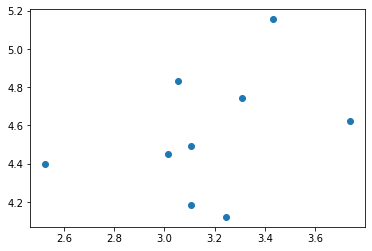

In [204]:
fig, ax = plt.subplots()
x = 6-np.log10(pd.to_numeric(df['IC50 (µM)'],errors='coerce'))
#x = df[column_name]
y = df['affinity_mean']
ax.scatter(x,y)

**NSP13**

In [205]:
df = pd.read_csv('/home/xvg/nsp13_inhibitors.csv')

In [211]:
list(df.columns)

['Raw_endpoint',
 'Normalised_endpoint',
 'Well No.',
 'Plate',
 'Well',
 'Well Contents',
 'Chemical Name',
 'Unnamed: 7',
 'Plate 1 and 5 are faulty plates',
 'smiles',
 'affinity_mean']

In [206]:
nsp13_seq = df_virus[df_virus['description'].str.contains('helicase')]['seq'].values[0]

In [207]:
nsp13_seq

'AVGACVLCNSQTSLRCGACIRRPFLCCKCCYDHVISTSHKLVLSVNPYVCNAPGCDVTDVTQLYLGGMSYYCKSHKPPISFPLCANGQVFGLYKNTCVGSDNVTDFNAIATCDWTNAGDYILANTCTERLKLFAAETLKATEETFKLSYGIATVREVLSDRELHLSWEVGKPRPPLNRNYVFTGYRVTKNSKVQIGEYTFEKGDYGDAVVYRGTTTYKLNVGDYFVLTSHTVMPLSAPTLVPQEHYVRITGLYPTLNISDEFSSNVANYQKVGMQKYSTLQGPPGTGKSHFAIGLALYYPSARIVYTACSHAAVDALCEKALKYLPIDKCSRIIPARARVECFDKFKVNSTLEQYVFCTVNALPETTADIVVFDEISMATNYDLSVVNARLRAKHYVYIGDPAQLPAPRTLLTKGTLEPEYFNSVCRLMKTIGPDMFLGTCRRCPAEIVDTVSALVYDNKLKAHKDKSAQCFKMFYKGVITHDVSSAINRPQIGVVREFLTRNPAWRKAVFISPYNSQNAVASKILGLPTQTVDSSQGSEYDYVIFTQTTETAHSCNVNRFNVAITRAKVGILCIMSDRDLYDKLQFTSLEIPRRNVATLQ'

In [208]:
len(nsp13_seq)

601

In [209]:
nsp13_dataset = InhibDataset(df,nsp13_seq,'smiles')

In [ ]:
y_pred=trainer.predict(nsp13_dataset)
df['affinity_mean'] = scale(y_pred.predictions)
#df['affinity_var'] = scale_var(y_pred.predictions[:,1])

In [213]:
from scipy.stats import spearmanr

x = df[~df['Normalised_endpoint'].isna()]['affinity_mean']
y = df[~df['Normalised_endpoint'].isna()]['Normalised_endpoint']
spearmanr(x,y)

SpearmanrResult(correlation=-0.02686093685390131, pvalue=0.0637625642283761)

**NSP14**

In [219]:
df = pd.read_csv('/home/xvg/nsp14_inhibitors.csv')

In [220]:
nsp14_seq = df_virus[df_virus['description'].str.contains('methyltransferase')]['seq'].values[0]

In [223]:
nsp14_seq

'SSQAWQPGVAMPNLYKMQRMLLEKCDLQNYGDSATLPKGIMMNVAKYTQLCQYLNTLTLAVPYNMRVIHFGAGSDKGVAPGTAVLRQWLPTGTLLVDSDLNDFVSDADSTLIGDCATVHTANKWDLIISDMYDPKTKNVTKENDSKEGFFTYICGFIQQKLALGGSVAIKITEHSWNADLYKLMGHFAWWTAFVTNVNASSSEAFLIGCNYLGKPREQIDGYVMHANYIFWRNTNPIQLSSYSLFDMSKFPLKLRGTAVMSLKEGQINDMILSLLSKGRLIIRENNRVVISSDVLVNN'

In [224]:
len(nsp14_seq)

298

In [228]:
nsp14_dataset = InhibDataset(df,seq=nsp14_seq,smiles_name='smiles')

In [229]:
# y_pred=trainer.predict(nsp14_dataset)
# df['affinity_mean'] = scale(y_pred.predictions[:,0])
# df['affinity_var'] = scale_var(y_pred.predictions[:,1])

In [ ]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(nsp14_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(len(model_files))],axis=0)

In [231]:
from scipy.stats import spearmanr

x = df[~df['zscore'].isna()]['affinity_mean']
y = df[~df['zscore'].isna()]['zscore']
spearmanr(x,y)

SpearmanrResult(correlation=0.011496358789026597, pvalue=0.4966209280074194)

**Spike**

In [208]:
df = pd.read_csv('/home/xvg/Spike-ACE2_protein-protein_interaction_(AlphaLISA).tsv',sep='\t')

In [209]:
from Bio import SeqIO

with open('/home/xvg/protein.faa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seq = []
    desc = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        seq.append(str(seq_record.seq))
        desc.append(seq_record.description)

df_virus = pd.DataFrame({'id': identifiers, 'seq': seq, 'description': desc})

In [210]:
spike_seq = df_virus[df_virus.id=='YP_009724390.1:1-1273']['seq'].values[0]

In [211]:
rbd_seq = spike_seq[318:541]

In [212]:
spike_dataset = InhibDataset(df,spike_seq,'SMILES')

In [213]:
rbd_dataset = InhibDataset(df,rbd_seq,'SMILES')

In [214]:
len(spike_seq)

1273

In [215]:
# y_pred=trainer.predict(spike_dataset)
# df['affinity_mean'] = scale(y_pred.predictions)
# #df['affinity_var'] = scale_var(y_pred.predictions[:,1])

In [ ]:
n = len(model_files)

n = 3
load_ensemble(0)

with dropout(trainer.model):
    for i in tqdm.auto.tqdm(range(n)):
        y_pred=trainer.predict(spike_dataset)
        df[f'affinity_spike_{i}'] = scale(y_pred.predictions)
    df['affinity_mean_spike'] = np.mean([df[f'affinity_spike_{i}'] for i in range(n)],axis=0)
    df['affinity_var_spike'] = np.var([df[f'affinity_spike_{i}'] for i in range(n)],axis=0)

In [308]:
n = len(model_files)

n = 3
load_ensemble(0)

with dropout(trainer.model):
    for i in tqdm.auto.tqdm(range(n)):
        y_pred=trainer.predict(rbd_dataset)
        df[f'affinity_rbd_{i}'] = scale(y_pred.predictions)
    df['affinity_mean_rbd'] = np.mean([df[f'affinity_rbd_{i}'] for i in range(n)],axis=0)
    df['affinity_var_rbd'] = np.var([df[f'affinity_rbd_{i}'] for i in range(n)],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


  0%|          | 0/3 [00:00<?, ?it/s]

RDKit ERROR: [04:36:27] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[04:36:27] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21

RDKit ERROR: 
RDKit ERROR: [04:36:27] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
[04:36:27] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18

RDKit ERROR: [04:36:28] Explicit valence for atom # 4 N, 4, is greater than permitted
[04:36:28] Explicit valence for atom # 4 N, 4, is greater than permitted


RDKit ERROR: [04:36:33] Can't kekulize mol.  Unkekulized atoms: 69 70 71 72 73 74 75 76 77
[04:36:33] Can't kekulize mol.  Unkekulized atoms: 69 70 71 72 73 74 75 76 77

RDKit ERROR: 
RDKit ERROR: [04:36:33] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[04:36:33] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17

RDKit ERROR: 
RDKit ERROR: [04:36:39] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 24
[04:36:39] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 24

RDKit ERROR: 
RDKit ERROR: [04:36:39] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[04:36:39] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19

RDKit ERROR: 
RDKit ERROR: [04:36:39] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 21
[04:36:39] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 21

RDKit ERROR: 
RDKit ERROR: [04:36:40] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDK

In [309]:
#df.to_parquet(f'spike.parquet')
#df = pd.read_parquet('spike.parquet')

In [310]:
from scipy.stats import spearmanr

df_select = df[~df['EFFICACY'].isna() & ~df['LOG_AC50'].isnull()]
x = df_select['affinity_mean_spike']
y = -df_select['EFFICACY']


#pickle.dump(s,open(f'spike_ncats_spearmanr_{tokenizer_type}.p','wb'))
spearmanr(x,y)#, mean_squared_error(y,x,sample_weight=1/df_select['affinity_var'])

SpearmanrResult(correlation=0.04825345735320704, pvalue=0.1199075376832835)

In [311]:
from scipy.stats import spearmanr

df_select = df[~df['EFFICACY'].isna() & ~df['LOG_AC50'].isnull()]

x = df_select['affinity_mean_rbd']
y = -df_select['EFFICACY']
spearmanr(x,y)

SpearmanrResult(correlation=0.1642064158248357, pvalue=1.0077741923331853e-07)

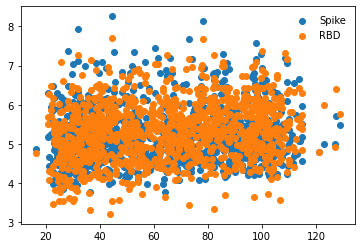

In [312]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
filt = ~df['EFFICACY'].isnull() & ~df['LOG_AC50'].isnull()
x = -df[filt]['EFFICACY']
y = df[filt]['affinity_mean_spike']
ax.scatter(x,y,label='Spike')

x = -df[filt]['EFFICACY']
y = df[filt]['affinity_mean_rbd']
ax.scatter(x,y,label='RBD')
ax.legend(frameon=False)

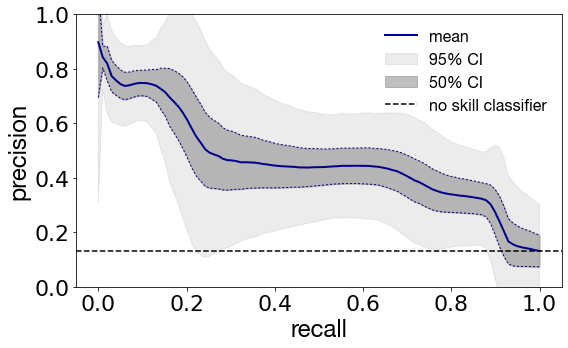

In [326]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = -20
nbootstrap = 500

x = np.linspace(0,1,100)
field = 'EFFICACY'

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
df_select = df[~df[field].isnull()]
samplesize = len(df_select)
ps = []
np.random.seed(42)
for i in range(nbootstrap):
    df_sample = df_select.sample(n=samplesize,replace=True) 
    yr = df_sample[field] < thresh
    #samples = np.random.normal(df_sample['affinity_mean_spike'],np.sqrt(df_sample['affinity_var_spike']))
    samples = df_sample['affinity_mean_rbd']
    p, r, _ = precision_recall_curve(yr,samples,sample_weight=1/df_sample['affinity_var_rbd'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='darkblue',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='darkblue',lw=1,dashes=[2,2])
ax.plot(x,upper,color='darkblue',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))
ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='upper right')
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

fig.tight_layout()
fig.savefig('ncats_rbd.png',dpi=300)

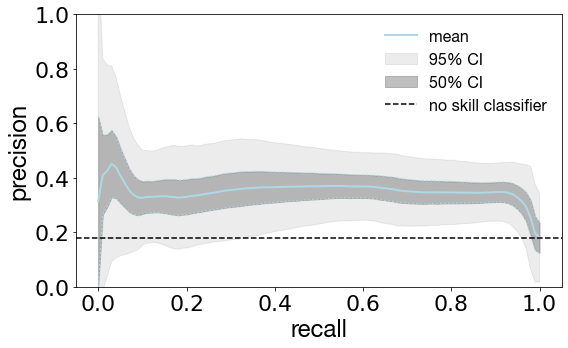

In [329]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = -25
nbootstrap = 500

x = np.linspace(0,1,100)
field = 'EFFICACY'

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
df_select = df[~df[field].isnull()]
samplesize = len(df_select)
ps = []
np.random.seed(42)
for i in range(nbootstrap):
    df_sample = df_select.sample(n=samplesize,replace=True) 
    yr = df_sample[field] < thresh
    #samples = np.random.normal(df_sample['affinity_mean_spike'],np.sqrt(df_sample['affinity_var_spike']))
    samples = df_sample['affinity_mean_spike']
    p, r, _ = precision_recall_curve(yr,samples,sample_weight=1/df_sample['affinity_var_spike'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='lightblue',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='lightblue',lw=1,dashes=[2,2])
ax.plot(x,upper,color='lightblue',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))
ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='upper right')
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

fig.tight_layout()
fig.savefig('ncats_spike.png',dpi=300)

**Test dataset**

In [380]:
data_all = load_dataset("jglaser/binding_affinity",split='train')
split = data_all.train_test_split(train_size=0.99, seed=0)
test = split['test']
test.set_transform(encode)

Using custom data configuration default
Reusing dataset binding_affinity (/home/xvg/.cache/huggingface/datasets/binding_affinity/default/1.1.0/c3689efc5574faa77f773a8ed645279368964074da4b44f704de2ae2253db772)
Loading cached split indices for dataset at /home/xvg/.cache/huggingface/datasets/binding_affinity/default/1.1.0/c3689efc5574faa77f773a8ed645279368964074da4b44f704de2ae2253db772/cache-79c61e19a6e82303.arrow and /home/xvg/.cache/huggingface/datasets/binding_affinity/default/1.1.0/c3689efc5574faa77f773a8ed645279368964074da4b44f704de2ae2253db772/cache-d2bddaacb2363d1f.arrow


In [378]:
class AffinityDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        #affinity = item['neg_log10_affinity_M']
        affinity = item['affinity']
        #affinity = (affinity**lmbda-1)/lmbda # transform
        #item['labels'] = torch.tensor(float(affinity))
        item['labels'] = affinity
        
        # drop the non-encoded input
        item.pop('smiles')
        item.pop('seq')
        item.pop('neg_log10_affinity_M')
        item.pop('affinity_uM')
        item.pop('affinity')
        return item

    def __len__(self):
        return len(self.dataset)

In [381]:
test_dataset = AffinityDataset(test)

In [135]:
# df = test.to_pandas()
# y_pred=trainer.predict(test_dataset)
# df['affinity_mean'] = scale(y_pred.predictions)
# #df['affinity_var'] = scale_var(y_pred.predictions[:,1])

In [ ]:
df = test.to_pandas()
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(test_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(len(model_files))],axis=0)

In [137]:
#df.to_parquet(f'test_2048.parquet')
#df = pd.read_parquet(f'test_2048.parquet')

In [138]:
from scipy.stats import spearmanr, pearsonr

nbootstrap = 500
samplesize = len(df)

sp = []
mse = []
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'])
#    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    samples = df_sample['affinity_mean']
    x = samples
    y = df_sample['neg_log10_affinity_M']

    import pickle
    s = spearmanr(x,y)
    sp.append(s.correlation)    
    mse.append(mean_squared_error(y,x))

print(np.mean(sp), np.std(sp))
print(np.mean(mse), np.std(mse))

0.8392547516351159 0.002546046296592983
0.7144045965577729 0.011475483131570255


In [140]:
from scipy.stats import spearmanr, pearsonr

for j in range(len(model_files)):
    nbootstrap = 500
    samplesize = len(df)

    sp = []
    mse = []
    for i in range(nbootstrap):
        df_sample = df.sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'])
    #    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
        samples = df_sample[f'affinity_{j}']
        x = samples
        y = df_sample['neg_log10_affinity_M']

        import pickle
        s = spearmanr(x,y)
        sp.append(s.correlation)    
        mse.append(mean_squared_error(y,x))
    print(f'Model {j}')
    print('rho', np.mean(sp), np.std(sp))
    print('MSE',np.mean(mse), np.std(mse))

Model 0
rho 0.8393196132698615 0.0024394106645473494
MSE 0.7134536130730654 0.010668903543825266


In [164]:
from scipy.stats import spearmanr

x = df['affinity_mean']
y = df['neg_log10_affinity_M']

spearman_test = spearmanr(x,y)

import pickle
pickle.dump(spearman_test,open(f'test_spearmanr_{tokenizer_type}.p','wb'))
print('{} ensemble model (n={}):'.format(tokenizer_type, len(model_files)))
print('Spearman rho {:.3f}'.format(spearmanr(x,y).correlation))
#print('Weighted MSE {:.3f}'.format(mean_squared_error(y,x,sample_weight=1/df['affinity_var'])))
print('MSE {:.3f}'.format(mean_squared_error(y,x)))

regex ensemble model (n=3):
Spearman rho 0.881
MSE 0.693


In [166]:
model_files

['/home/xvg/affinity_pred/train/ensemble_regex_mse/pytorch_model_2_5368.bin',
 '/home/xvg/affinity_pred/train/ensemble_regex_mse/pytorch_model_5_5246.bin',
 '/home/xvg/affinity_pred/train/ensemble_regex_mse/pytorch_model_3_5490.bin']

In [142]:
from scipy.stats import spearmanr

for i in range(len(model_files)):
    x = df[f'affinity_{i}']
    y = df['neg_log10_affinity_M']

    spearman_test = spearmanr(x,y)

    import pickle
    pickle.dump(spearman_test,open(f'test_spearmanr_{tokenizer_type}.p','wb'))
    print('{} model {}: Spearman rho {:.3f} MSE {:.3f}'.format(tokenizer_type, i,
                                                               spearmanr(x,y).correlation,
                                                               mean_squared_error(y,x)))

regex model 0: Spearman rho 0.866 MSE 0.776
regex model 1: Spearman rho 0.865 MSE 0.793
regex model 2: Spearman rho 0.866 MSE 0.746


In [17]:
# n=5
# df_regex = pd.read_parquet('df_test_new_pretrain_regex.parquet')
# df_bert = pd.read_parquet('df_test_new_pretrain_bert.parquet')
# df_both = df_regex.copy().rename(columns={'affinity_mean_{}'.format(i): 'affinity_mean_regex_{}'.format(i) for i in range(1,n+1)})
# df_both = df_both.rename(columns={'affinity_var_{}'.format(i): 'affinity_var_regex_{}'.format(i) for i in range(1,n+1)})
# for i in range(1,n+1):
#     df_both['affinity_mean_bert_{}'.format(i)] = df_bert['affinity_mean_{}'.format(i)]
#     df_both['affinity_var_bert_{}'.format(i)] = df_bert['affinity_var_{}'.format(i)]
# df_both['affinity_mean'] = np.mean([df_both['affinity_mean_regex_{}'.format(i)] for i in range(1,n+1)]+[df_both['affinity_mean_bert_{}'.format(i)] for i in range(1,n+1)], axis=0)
# df_both['affinity_var'] = np.mean([df_both['affinity_var_regex_{}'.format(i)]+df_both['affinity_mean_regex_{}'.format(i)]**2-df_both['affinity_mean']**2 for i in range(1,n+1)]
#                                   +[df_both['affinity_var_bert_{}'.format(i)]+df_both['affinity_mean_bert_{}'.format(i)]**2-df_both['affinity_mean']**2 for i in range(1,n+1)], axis=0)
# #df = df_both

/home/xvg/miniconda3/envs/affinity/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


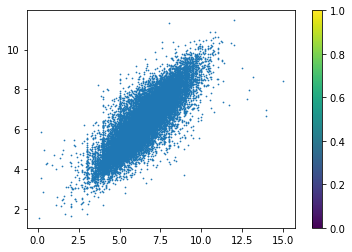

In [141]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots()
x = df['neg_log10_affinity_M']
y = df['affinity_mean']
z = np.log(df['affinity_var'])
#p = ax.scatter(x,y,c=z,s=0.5)
p = ax.scatter(x,y,s=0.5)
fig.colorbar(p)

In [20]:
n=5
print('{} MSE ensemble :'.format(tokenizer_type),mean_squared_error(df['neg_log10_affinity_M'],df['affinity_mean']))
for i in range(1,n+1):
    print(mean_squared_error(df['neg_log10_affinity_M'],df[f'affinity_mean_{i}']))

regex MSE ensemble : 0.99997276
1.0502187
1.1476265
1.1281434
1.0924197
1.0908533


In [20]:
n=5
print('{} MSE ensemble :'.format(tokenizer_type),mean_squared_error(df['neg_log10_affinity_M'],df['affinity_mean']))
for i in range(1,n+1):
    print(mean_squared_error(df['neg_log10_affinity_M'],df[f'affinity_mean_{i}']))

regex MSE ensemble : 0.99997276
1.0502187
1.1476265
1.1281434
1.0924197
1.0908533


In [22]:
n=5
print('MSE 2-tokenizer-ensemble :'.format(tokenizer_type),mean_squared_error(df_both['neg_log10_affinity_M'],df_both['affinity_mean']))

MSE 2-tokenizer-ensemble : 0.99265736


In [22]:
n=5
print('{} MSE ensemble :'.format(tokenizer_type),mean_squared_error(df['neg_log10_affinity_M'],df['affinity_mean']))
for i in range(1,n+1):
    print(mean_squared_error(df['neg_log10_affinity_M'],df[f'affinity_mean_{i}']))

bert MSE ensemble : 1.030037
0.9550826
0.94930094
1.1833744
1.3695463
1.2083477


In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
thresh = 6
df_select = df[df['neg_log10_affinity_M'] >= thresh]
ax.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=0.1,alpha=0.5)
df_select = df[df['neg_log10_affinity_M'] < thresh]
ax.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=0.1,alpha=0.5)
#p = ax.scatter(np.log(df_select['affinity_var']),np.abs(df_select['affinity_mean']-df_select['neg_log10_affinity_M']),s=0.1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
n=5
print('MSE 2-tokenizer-ensemble :'.format(tokenizer_type),mean_squared_error(df_both['neg_log10_affinity_M'],df_both['affinity_mean']))

MSE 2-tokenizer-ensemble : 0.99265736


In [63]:
ax = df['affinity_var'].hist(bins=250)
ax.set_xlim(0,2.5)

(0.0, 2.5)

In [28]:
np.log(df['affinity_var'].quantile(0.005))

-3.6307136833696756

In [31]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.constants import golden
import numpy as np

thresh = 9
nbootstrap = 500

x = np.linspace(0,1,250)

samplesize = len(df)

ps = []
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)
    #yr = df_sample['affinity_exp'] >= thresh
    yr = df_sample['neg_log10_affinity_M']>= thresh
    #samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    p, r, _ = precision_recall_curve(yr,df_sample['affinity_mean'])
#    p, r, _ = precision_recall_curve(yr,df_sample['proba'])
#                                     sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    #r, p, _ = roc_curve(yr, df_sample.prediction)
    #ps.append(np.interp(x,r,p))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15
fig, ax = plt.subplots()
fig.set_size_inches(10.5,10.5/golden)

ax.plot(x,pavg,label='active = $-\\log_{{10}} \\mathrm{{IC50}} [\\mathrm{{M}}] > {:.2f}$'.format(thresh),color='b',lw=4)
ax.fill_between(x, pavg - perr, pavg + perr, color='b', alpha=alpha_err)

ax.axhline(pavg[-1],ls='--',color='darkblue',label='no skill')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=36)
ax.set_ylabel('precision',fontsize=36)
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,title='Test dataset',fontsize=16)
l.get_title().set_fontsize(20)

fig.tight_layout()
fig.savefig('test_dataset_new_pretrain.png',dpi=300)
fig.savefig('test_dataset_new_pretrain.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
thresh = 6
df_select = df[df['neg_log10_affinity_M'] >= thresh]
ax.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=0.1,alpha=0.5)
df_select = df[df['neg_log10_affinity_M'] < thresh]
ax.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=0.1,alpha=0.5)
#p = ax.scatter(np.log(df_select['affinity_var']),np.abs(df_select['affinity_mean']-df_select['neg_log10_affinity_M']),s=0.1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

**DeepDTA Davis/Kiba datasets**

In [168]:
import pickle
import json
dataset = 'davis'
#dataset = 'kiba'
Y = pickle.load(open(f"/home/xvg/DeepDTA/data/{dataset}/Y", "rb"),encoding='latin1')
#affinities = np.loadtxt('/home/xvg/DeepDTA/data/kiba/kiba_binding_affinity_v2.txt')
label_row_inds, label_col_inds = np.where(np.isnan(Y)==False)
ligands = np.array(list(json.load(open(f"/home/xvg/DeepDTA/data/{dataset}/ligands_can.txt")).values()))
proteins = np.array(list(json.load(open(f"/home/xvg/DeepDTA/data/{dataset}/proteins.txt")).values()))

In [169]:
import json
yourdir = '/home/xvg/DeepDTA/data/{}/'.format(dataset)
test_fold = json.load(open(yourdir + "folds/test_fold_setting1.txt"))
train_folds = json.load(open(yourdir + "folds/train_fold_setting1.txt"))

test_drug_indices = label_row_inds[test_fold]
test_protein_indices = label_col_inds[test_fold]

In [170]:
df = pd.DataFrame({f'{dataset}': [Y[r,c] if dataset == 'kiba' else 9-np.log(Y[r,c])/np.log(10) for r,c in zip(test_drug_indices,test_protein_indices)],
                   'seq': proteins[test_protein_indices],
                   'smiles': ligands[test_drug_indices]})

In [171]:
class DTADataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]

        item = {'seq': [row.seq]}
        try:
            # make canonical
            item['smiles_can'] = [str(Chem.MolToSmiles(Chem.MolFromSmiles(row.smiles)))]
        except:
            item['smiles_can'] = [str(row.smiles)]
            pass
        item = encode(item)
        
        # get first (single) item
        item['input_ids_1'] = item['input_ids_1'][0]
        item['attention_mask_1'] = item['attention_mask_1'][0]
        item['input_ids_2'] = item['input_ids_2'][0]
        item['attention_mask_2'] = item['attention_mask_2'][0]
        
        
        # drop the non-encoded input
        item.pop('smiles_can')
        item.pop('seq')
        return item

    def __len__(self):
        return len(self.dataset)

In [172]:
dta_dataset = DTADataset(df)

In [173]:
# y_pred=trainer.predict(dta_dataset)
# df['affinity_mean'] = scale(y_pred.predictions)
#df['affinity_var']= scale_var(y_pred.predictions[:,1])

In [174]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(dta_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [176]:
# uncommment to load paper results

#df.to_parquet(f'{dataset}.parquet')
#df = pd.read_parquet(f'{dataset}_{tokenizer_type}.parquet')

In [175]:
from scipy.stats import spearmanr, pearsonr

nbootstrap = 500
samplesize = len(df)

sp = []
mse = []
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'])
#    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    samples = df_sample['affinity_mean']
    x = samples
    y = df_sample[dataset]

    import pickle
    s = spearmanr(x,y)
    sp.append(s.correlation)    
    mse.append(mean_squared_error(y,x))

#pickle.dump([np.mean(sp),np.std(sp)],open(f'{dataset}_spearmanr_{tokenizer_type}.p','wb'))
print(np.mean(sp), np.std(sp))
print(np.mean(mse), np.std(mse))

0.35683244587687846 0.013246947891561084
1.1253047794366962 0.021841109758993532


In [177]:
from scipy.stats import spearmanr, pearsonr

for j in range(len(model_files)):
    nbootstrap = 500
    samplesize = len(df)

    sp = []
    mse = []
    for i in range(nbootstrap):
        df_sample = df.sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'])
    #    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
        samples = df_sample[f'affinity_{j}']
        x = samples
        y = df_sample[dataset]

        import pickle
        s = spearmanr(x,y)
        sp.append(s.correlation)    
        mse.append(mean_squared_error(y,x))
    print(f'Model {j}')
    print('rho', np.mean(sp), np.std(sp))
    print('MSE',np.mean(mse), np.std(mse))

Model 0
rho 0.3565115293213967 0.01342596241765908
MSE 1.1260619594115437 0.021788401568152514


In [178]:
from scipy.stats import spearmanr
df_select = df.copy()#[df[dataset] > 7]
if dataset == 'davis':
    df_select = df_select#[~(df_select[dataset]==5)].reset_index(drop=True)

x = df_select['affinity_mean']
y = df_select[dataset]
c = -np.log(df_select['affinity_var'])

import pickle
s = spearmanr(x,y)
#pickle.dump(s,open(f'{dataset}_spearmanr_{tokenizer_type}.p','wb'))
spearmanr(x,y), mean_squared_error(y,x,sample_weight=1/df_select['affinity_var'])

/home/xvg/miniconda3/envs/affinity/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/xvg/miniconda3/envs/affinity/lib/python3.8/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in true_divide
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


(SpearmanrResult(correlation=0.3573074249039239, pvalue=9.224620963027658e-151),
 nan)

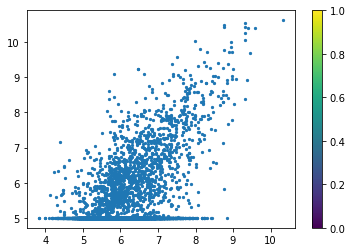

In [179]:
fig,ax = plt.subplots()
#p = ax.scatter(x,y,c=c,s=5)
p = ax.scatter(x,y,s=5)
fig.colorbar(p)

**Kuzikov 3CL screen** https://pubs.acs.org/doi/10.1021/acsptsci.0c00216

In [144]:
df = pd.read_csv('/home/xvg/pt0c00216_si_002.csv').dropna().reset_index(drop=True)
df['Smiles'] = df['Smiles'].str.replace(" ","").str.replace("\n","").str.replace('\t',"")

In [145]:
kuzikov_dataset = InhibDataset(df=df, seq=mpro_seq_uniprot, smiles_name='Smiles')

In [147]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(kuzikov_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


RDKit ERROR: [12:28:27] Explicit valence for atom # 11 N, 4, is greater than permitted
[12:28:27] Explicit valence for atom # 11 N, 4, is greater than permitted


RDKit ERROR: [12:28:41] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:28:41] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [12:28:45] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:28:45] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [12:30:34] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[12:30:34] Explicit valence for atom # 0 Cl, 2, is greater than permitted
RDKit ERROR: [12:30:39] Explicit valence for atom # 2 O, 3, is greater than permitted
[12:30:39] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [12:30:43] Explicit valence for atom # 19 N, 4, is greater than permitted
[12:30:43] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [12:30:53] SMILES Parse Error: syntax error while parsing: CNC([C@@H](C1=CC=CC=C1)N2CCC3=CC(OC)=C(OC)C=C3[C@@H]2CCC4=CC=C(C(F)(F)F)C=C4)=O.
[12:30:53] SMILES Parse Error: syntax error whil

In [157]:
#df.to_parquet('kuzikov.parquet')
#df = pd.read_parquet('kuzikov.parquet')

In [149]:
from scipy.stats import spearmanr

x = df['3CL-Pro Inhibition [%] Primary Screen (20 µM)']
y = df['affinity_mean']

spearmanr(x,y)

SpearmanrResult(correlation=-0.09616469178140036, pvalue=2.467164412634312e-19)

<AxesSubplot:>

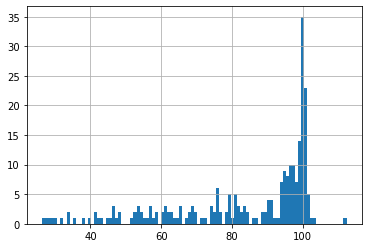

In [153]:
 df[df['Selected for HC']!='N']['3CL-Pro Inhibition [%] Primary Screen (20 µM)'].hist(bins=100)

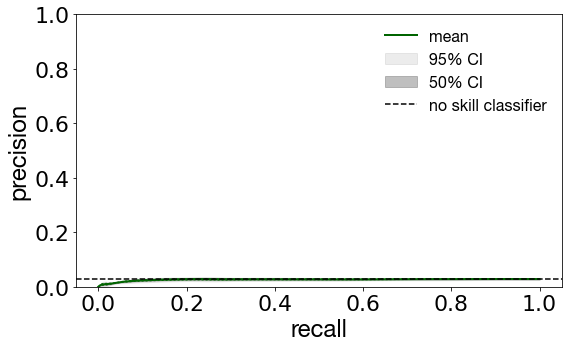

In [155]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = 10
nbootstrap = 1000

x = np.linspace(0,1,250)
field = '3CL-Pro Inhibition [%] Primary Screen (20 µM)'

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
df_select = df[~df[field].isnull()]
samplesize = len(df_select)
ps = []
np.random.seed(42)
for i in range(nbootstrap):
    df_sample = df_select.sample(n=samplesize,replace=True) 
    yr = df_sample['Selected for HC'] != 'N'
    #yr = df_sample[field] > thresh
    samples = df_sample['affinity_mean']
    p, r, _ = precision_recall_curve(yr,samples)#,sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='darkgreen',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='darkgreen',lw=1,dashes=[2,2])
ax.plot(x,upper,color='darkgreen',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))
ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')


ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='upper right')
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

fig.tight_layout()
fig.savefig('kuzikov_mpro.png',dpi=300)

**NCATS Mpro**

In [243]:
df = pd.read_csv('data/3CL_enzymatic_activity.tsv',sep='\t')
#df = df[df['LOG_AC50'].notnull()].reset_index(drop=True)

In [244]:
ncats_dataset = InhibDataset(df=df, seq=mpro_seq_uniprot,smiles_name='SMILES')

In [245]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(ncats_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


RDKit ERROR: [16:43:10] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 16 17
[16:43:10] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 16 17

RDKit ERROR: 


RDKit ERROR: [16:43:14] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:43:14] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13

RDKit ERROR: 
RDKit ERROR: [16:43:15] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[16:43:15] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29

RDKit ERROR: 
RDKit ERROR: [16:43:15] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:43:15] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21

RDKit ERROR: 
RDKit ERROR: [16:43:19] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[16:43:19] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21

RDKit ERROR: 
RDKit ERROR: [16:43:19] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:43:19] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18

RDKit ERROR: 
RDKit ERROR: [16:43:19] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[16:43:19] Can't kekuliz

In [251]:
#df.to_parquet('ncats_mpro.parquet')
#df = pd.read_parquet('ncats_mpro.parquet')

In [252]:
from scipy.stats import spearmanr

filt = ~df['EFFICACY'].isnull()# & (~df['LOG_AC50'].isnull())
x = -df[filt]['EFFICACY']
y = df[filt]['affinity_mean']

spearmanr(x,y)

SpearmanrResult(correlation=0.07247784549009567, pvalue=2.7300788891885463e-15)

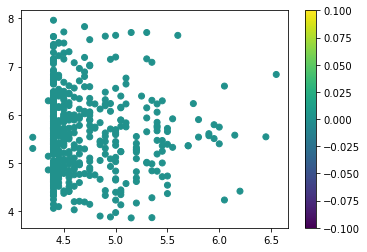

In [253]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = -df[filt]['LOG_AC50']
y = df[filt]['affinity_mean']
z = df[filt]['affinity_var']
p = ax.scatter(x,y,c=z)
fig.colorbar(p)

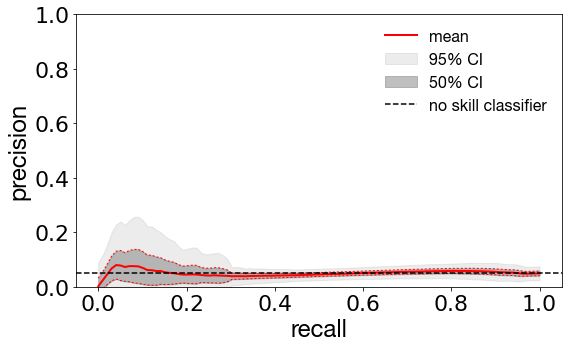

In [258]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = -5.5
nbootstrap = 500

x = np.linspace(0,1,100)
field = 'LOG_AC50'

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
df_select = df[~df[field].isnull() & (df['EFFICACY'] < 0)]
samplesize = len(df_select)
ps = []
np.random.seed(42)
for i in range(nbootstrap):
    df_sample = df_select.sample(n=samplesize,replace=True) 
    yr = df_sample[field] < thresh
    #samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    samples = df_sample['affinity_mean']
    p, r, _ = precision_recall_curve(yr,samples)#,sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))
ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='upper right')
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

fig.tight_layout()
fig.savefig('ncats_mpro.png',dpi=300)

**Mpro inhibitors predicted by sparse attention model, uniform distribution**

In [581]:
df_uniform = pd.read_csv('/home/xvg/uniform.csv')

In [582]:
uniform_dataset = InhibDataset(df_uniform,seq=mpro_seq_5r84)

In [583]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(uniform_dataset)
    df_uniform[f'affinity_{i}'] = scale(y_pred.predictions)
df_uniform['affinity_mean'] = np.mean([df_uniform[f'affinity_{i}'] for i in range(n)],axis=0)
df_uniform['affinity_var'] = np.var([df_uniform[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


In [593]:
df_order = pd.read_csv('/home/xvg/order_enamine_z178890-108-1398601.csv')

In [594]:
#df_order[['ID','Smile']].to_csv('/home/xvg/DeepSCAMs/test.txt',sep='\t', index=False)
#! cd /home/xvg/DeepSCAMs; python DeepSCAMs.py
df_agg = pd.read_csv('/home/xvg/DeepSCAMs/test_preds.txt',sep='\t')

In [595]:
df_order = df_order.merge(df_agg,on='ID')
df_order.index += 1

In [596]:
df_order

,ID,CatalogID,Formula,Barcode_1,MW,Purity,PO,Salt_Name,Salt_ratio,MW_salt,...,Well_2,Stereochem.data,Geometric.isomer,Smile,Name,index,CXSMILES,Preds,Prob_0,Prob_1
1,PV-004106684588,Z5197597801,C19H29FN4O2,1215699846,364.457,96,NaN,NaN,NaN,0,...,A01,Diastereomeric mixture,None,CC(C)C1=CC(=NN1)C(=O)NC2CCN(C2)C(=O)C(F)C3CCCCC3,N-[1-(2-cyclohexyl-2-fluoroacetyl)pyrrolidin-3...,141,CC(C)c1cc(n[nH]1)C(=O)NC2CCN(C2)C(=O)C(F)C3CCCCC3,0,0.997828,0.002172
2,Z4051673002,Z4051673002,C21H30N6O2,1215699847,398.501,97,NaN,NaN,NaN,0,...,B01,Achiral,None,CC(C)C1=CC(=NN1)C(=O)N2CCN(CC3(CC3)C2)C(=O)C=4...,"5,8-bis[5-(propan-2-yl)-1H-pyrazole-3-carbonyl...",113,CC(C)c1cc(n[nH]1)C(=O)N2CCN(CC3(CC3)C2)C(=O)c4...,0,0.999891,0.000109
3,Z2832518906,Z2832518906,C15H16FN5,1215699848,285.319,100,NaN,NaN,NaN,0,...,C01,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(C)C3,4-[(2-ethyl-1H-imidazol-1-yl)methyl]-1-(4-fluo...,112,CCc1nccn1Cc2cn(nn2)c3ccc(F)c(C)c3,0,0.992810,0.007190
4,Z4151005893,Z4151005893,C15H16FN5O,1215699849,301.318,100,NaN,NaN,NaN,0,...,D01,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(CO)C3,"(5-{4-[(2-ethyl-1H-imidazol-1-yl)methyl]-1H-1,...",81,CCc1nccn1Cc2cn(nn2)c3ccc(F)c(CO)c3,0,0.995791,0.004209
5,PV-003687523072,Z5197597811,C14H13ClFN5,1215699851,305.737,100,NaN,NaN,NaN,0,...,F01,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=C(F)C=C(Cl)C3,1-(3-chloro-5-fluorophenyl)-4-[(2-ethyl-1H-imi...,4,CCc1nccn1Cc2cn(nn2)c3cc(F)cc(Cl)c3,0,0.980981,0.019019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,PV-001418455359,Z5197596837,C21H31N3O2,1215699543,357.489,96,NaN,NaN,NaN,0,...,B11,Racemic or presumed racemic or meso,None,O=C(CCC1CCCC1)NC2CCN(C2)C(=O)C=3C=CNC3C4CCC4,N-[1-(2-cyclobutyl-1H-pyrrole-3-carbonyl)pyrro...,84,O=C(CCC1CCCC1)NC2CCN(C2)C(=O)c3cc[nH]c3C4CCC4,0,0.997462,0.002538
156,PV-004075616921,Z5197596851,C21H32N2O3,1215699544,360.490,93,NaN,NaN,NaN,0,...,C11,Diastereomeric mixture,None,CCC=1C=CC=CC1CC(=O)NC2CCN(C2)C(=O)C(O)C(C)(C)CC,"2-(2-ethylphenyl)-N-[1-(2-hydroxy-3,3-dimethyl...",15,CCc1ccccc1CC(=O)NC2CCN(C2)C(=O)C(O)C(C)(C)CC,0,0.993330,0.006670
157,PV-004084061887,Z5197596841,C18H28N6O2,1215699545,360.453,98,NaN,NaN,NaN,0,...,D11,Diastereomeric mixture,None,CC(C)C(NC(=O)CN1C=CC=N1)C(C)NC(=O)C=2C=C(NN2)C...,N-(2-methyl-4-{[5-(propan-2-yl)-1H-pyrazol-3-y...,130,CC(C)C(NC(=O)Cn1cccn1)C(C)NC(=O)c2cc([nH]n2)C(C)C,0,0.998357,0.001643
158,PV-001258276914,Z5197596892,C18H28N2O3S,1215699547,352.491,100,NaN,NaN,NaN,0,...,F11,Diastereomeric mixture,None,CCC(C)CCC(=O)NC1CC(CNC(=O)C2=CC(OC)=CS2)C1,4-methoxy-N-{[3-(4-methylhexanamido)cyclobutyl...,136,CCC(C)CCC(=O)NC1CC(CNC(=O)c2cc(OC)cs2)C1,0,0.993624,0.006376


<AxesSubplot:>

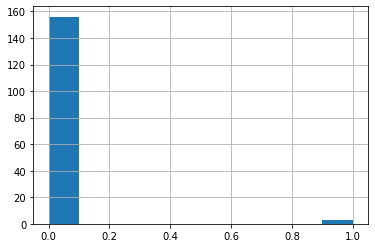

In [597]:
df_order['Preds'].hist()

In [79]:
cpd_37 = 'PV-000465323374'
cpd_37_catalog = ['Z5197597776']
cpd_39 = 'Z1646186285'
cpd_39_catalog = 'Z1646186285'
cpd_46 = 'PV-003247654624'
cpd_46_catalog = 'Z5197597797'
cpd_122 = 'PV-003965461894'
cpd_122_catalog = 'Z5197596845'
cpds = {'122': cpd_122, '37': cpd_37, '39': cpd_39, '46': cpd_46}

In [599]:
df_order[df_order['ID'].isin(cpds.values())]

,ID,CatalogID,Formula,Barcode_1,MW,Purity,PO,Salt_Name,Salt_ratio,MW_salt,...,Well_2,Stereochem.data,Geometric.isomer,Smile,Name,index,CXSMILES,Preds,Prob_0,Prob_1
37,PV-000465323374,Z5197597776,C17H22N4O2S,1215699887,346.447,100,NaN,NaN,NaN,0,...,B06,Racemic or presumed racemic or meso,None,CC(C)C1=CC(=NN1)C(=O)N2CCC(C2)NC(=O)C3=CSC(C)=C3,5-methyl-N-{1-[5-(propan-2-yl)-1H-pyrazole-3-c...,139,CC(C)c1cc(n[nH]1)C(=O)N2CCC(C2)NC(=O)c3csc(C)c3,0,0.999055,0.000945
39,Z1646186285,Z1646186285,C14H13ClFN5,1215699889,305.737,100,NaN,NaN,NaN,0,...,D06,Achiral,None,CCC1=NC=CN1CC2=CN(N=N2)C=3C=CC(F)=C(Cl)C3,1-(3-chloro-4-fluorophenyl)-4-[(2-ethyl-1H-imi...,111,CCc1nccn1Cc2cn(nn2)c3ccc(F)c(Cl)c3,0,0.983828,0.016172
46,PV-003247654624,Z5197597797,C15H23FN4O2,1215699897,310.367,98,NaN,NaN,NaN,0,...,D07,Diastereomeric mixture,None,CC(C)C1=CC(=NN1)C(=O)N2CCC(C2)NC(=O)CC(C)F,3-fluoro-N-{1-[5-(propan-2-yl)-1H-pyrazole-3-c...,27,CC(C)c1cc(n[nH]1)C(=O)N2CCC(C2)NC(=O)CC(C)F,0,0.999964,0.000036
122,PV-003965461894,Z5197596845,C20H22N6O,1215699505,362.428,100,NaN,NaN,NaN,0,...,D06,Diastereomeric mixture,Unknown,CC1=NC=CN1CC2=CN(N=N2)C=3C=CC=C(C3)C(=O)N4CC5C...,6-(3-{4-[(2-methyl-1H-imidazol-1-yl)methyl]-1H...,114,Cc1nccn1Cc2cn(nn2)c3cccc(c3)C(=O)N4CC5CCCC54,0,0.804937,0.195063


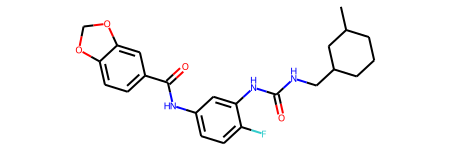

In [600]:
Chem.MolFromSmiles(df_order.sort_values(by='Prob_1',ascending=False).iloc[0]['Smile'])

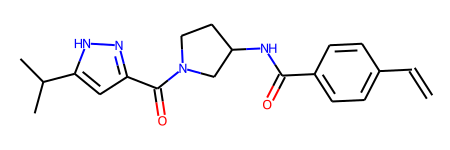

In [601]:
Chem.MolFromSmiles(df_order.iloc[37]['Smile'])

In [602]:
df_order[df_order['Preds']==1]

,ID,CatalogID,Formula,Barcode_1,MW,Purity,PO,Salt_Name,Salt_ratio,MW_salt,...,Well_2,Stereochem.data,Geometric.isomer,Smile,Name,index,CXSMILES,Preds,Prob_0,Prob_1
85,Z1276053077,Z1276053077,C22H25F2NO2,1215699463,373.436,100,NaN,NaN,NaN,0,...,B01,Racemic or presumed racemic or meso,None,COC=1C=CC=C(C1)C2(CCCC2)C(=O)NCC(C)C=3C=CC(F)=...,"N-[2-(3,4-difluorophenyl)propyl]-1-(3-methoxyp...",47,COc1cccc(c1)C2(CCCC2)C(=O)NCC(C)c3ccc(F)c(F)c3,1,0.485646,0.514354
89,PV-002725055409,Z5197596902,C15H13ClN2O3S,1215699468,336.793,99,NaN,NaN,NaN,0,...,G01,Achiral,None,NS(=O)(=O)C=1C=CC(=CC1)C=2C=C(Cl)C=C3C(=O)NCCC23,"4-(7-chloro-1-oxo-1,2,3,4-tetrahydroisoquinoli...",74,NS(=O)(=O)c1ccc(cc1)c2cc(Cl)cc3C(=O)NCCc23,1,0.383287,0.616713
97,Z813369256,Z813369256,C23H26FN3O4,1215699477,427.468,100,NaN,NaN,NaN,0,...,H02,Diastereomeric mixture,Unequal mixture of geometric isomers,CC1CCCC(CNC(=O)NC=2C=C(NC(=O)C=3C=CC=4OCOC4C3)...,N-[4-fluoro-3-({[(3-methylcyclohexyl)methyl]ca...,110,CC1CCCC(CNC(=O)Nc2cc(NC(=O)c3ccc4OCOc4c3)ccc2F)C1,1,0.258791,0.741209


In [603]:
from rdkit.Chem.Crippen import MolLogP
from rdkit import Chem
df_order['logp'] = [MolLogP(Chem.MolFromSmiles(s)) for s in df_order.CXSMILES]

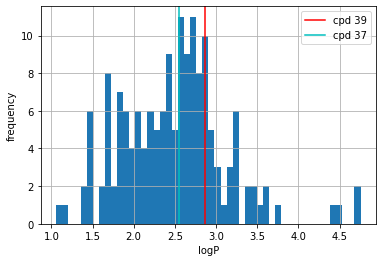

In [604]:
ax = df_order['logp'].hist(bins=50)
ax.axvline(df_order[df_order.ID==cpd_39].iloc[0]['logp'],color='r',label='cpd 39')
ax.axvline(df_order[df_order.ID==cpd_37].iloc[0]['logp'],color='c',label='cpd 37')
ax.legend()
ax.set_xlabel('logP')
ax.set_ylabel('frequency')
ax.get_figure().savefig('logP.png')

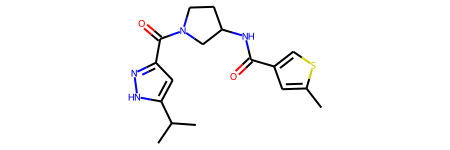

In [605]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_37].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_37.png')
m

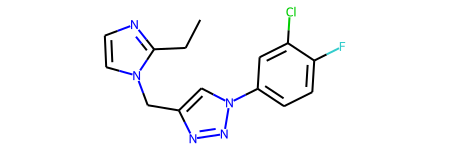

In [606]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_39].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_39.png')
m

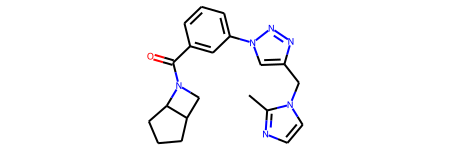

In [607]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_122].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_122.png')
m

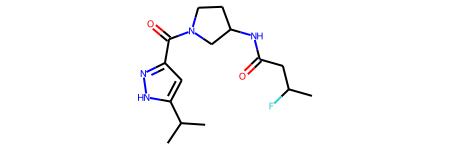

In [608]:
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(df_order[df_order.ID==cpd_46].iloc[0].CXSMILES)
Draw.MolToFile(m,'cpd_46.png')
m

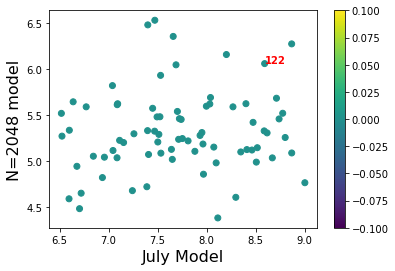

In [609]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df_select = df_uniform[df_uniform['idnumber'].isin(df_order['ID'])]
x = df_select['mean']
y = df_select['affinity_mean']
z = df_select['affinity_var']
p = ax.scatter(x,y,c=z,label='top')

for no,cpd in cpds.items():
    try:
        x = df_select[df_select['idnumber']==cpd].iloc[0]['mean']
        y = df_select[df_select['idnumber']==cpd].iloc[0]['affinity_mean']
        ax.text(x+0.005,y,no,color='r',weight='bold')
    except:
        pass
        
fig.colorbar(p)
ax.set_xlabel('July Model',fontsize=16)
ax.set_ylabel('N=2048 model',fontsize=16)
fig.savefig('sparse_attention_vs_regex_uniform.png',dpi=300)

In [280]:
smi_39

'CCc1nccn1Cc1cn(-c2ccc(F)c(Cl)c2)nn1'

**Mpro inhibitors predicted by sparse attention model, top inhibs**

In [69]:
df_top = pd.read_csv('/home/xvg/mpro_candidates_top.csv')

In [74]:
df_order = pd.read_csv('/home/xvg/order_enamine_z178890-108-1398601.csv')

In [75]:
#df_order = pd.read_csv('/home/xvg/ORNL_August31.csv')

In [76]:
top_dataset = InhibDataset(df_top,seq=mpro_seq_5r84)

In [77]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(top_dataset)
    df_top[f'affinity_{i}'] = scale(y_pred.predictions)
df_top['affinity_mean'] = np.mean([df_top[f'affinity_{i}'] for i in range(n)],axis=0)
df_top['affinity_var'] = np.var([df_top[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


37 mean = 5.6852147398272574 var = 0.0
39 mean = 6.965245307137584 var = 0.0
46 mean = 5.6819813041490415 var = 0.0


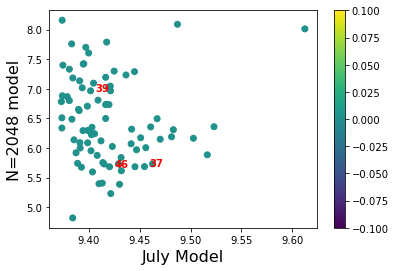

In [80]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df_select = df_top[df_top['idnumber'].isin(df_order['ID'])]

x = df_select['mean']
y = df_select['affinity_mean']
z = df_select['affinity_var']
p = ax.scatter(x,y,c=z,label='top')

for no,cpd in cpds.items():
    try:
        x = df_select[df_select['idnumber']==cpd].iloc[0]['mean']
        y = df_select[df_select['idnumber']==cpd].iloc[0]['affinity_mean']
        ax.text(x+0.005,y,no,weight='bold',color='r')
        print('{} mean = {} var = {}'.format(no,y,df_select[df_select['idnumber']==cpd].iloc[0]['affinity_var']))
    except:
        pass
fig.colorbar(p)
ax.set_xlabel('July Model',fontsize=16)
ax.set_ylabel('N=2048 model',fontsize=16)
fig.savefig('sparse_attention_vs_regex_top.png',dpi=300)

In [ ]:
df_select.sort_values(by='affinity_mean',ascending=False)['affinity_mean']

In [ ]:
smi = df_select.sort_values(by='affinity_mean',ascending=False)['smiles'].iloc[0]
#smi = df_select.sort_values(by='affinity_var',ascending=True)['smiles'].iloc[0]

mol = Chem.MolFromSmiles(smi)
mol

In [ ]:
df_merge = df_order.merge(df_top,left_on='ID',right_on='idnumber')
#df_merge.sort_values(by='affinity_mean',ascending=False).iloc[0]
df_merge.sort_values(by='affinity_var',ascending=True).iloc[0]

**Kneller et al** https://pubs.acs.org/doi/abs/10.1021/acs.jmedchem.1c01475

In [62]:
df = pd.read_csv('/home/xvg/jm1c01475_si_002.csv')

In [63]:
kneller_dataset = InhibDataset(df, seq=mpro_seq_uniprot, smiles_name='SMILES')

In [64]:
def make_numeric(ic50): 
    try:
        return float(ic50.replace('<','').replace('>','').split('-')[-1].split('~')[-1])
    except Exception as e:
        return np.nan

In [65]:
df['pIC50'] = 6-np.log(df['IC50, microM'].apply(make_numeric).astype('float32'))/np.log(10)

In [66]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(kneller_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


In [67]:
from scipy.stats import spearmanr
x = df['pIC50']
y = df['affinity_mean']
spearmanr(x,y)

SpearmanrResult(correlation=0.25207264925875916, pvalue=0.2836523405302126)

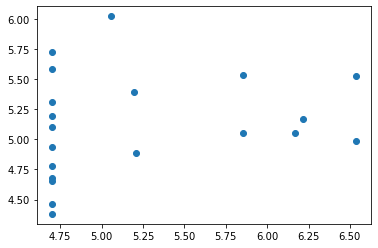

In [68]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = df['pIC50']
y = df['affinity_mean']
ax.scatter(x,y)

**KRAS G12V**

In [89]:
kras_wildtype_seq = 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'
kras_g12v_seq = 'MTEYKLVVVGAVGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'
kras_g12d_seq = 'MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'

In [90]:
kras_g12d_seq = 'MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLK'
kras_wildtype_seq_short = 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLK'


In [91]:
len(kras_g12d_seq)

169

In [92]:
smiles = ['CC(C)NCC(COC1=CC=CC2=C1NC=C2)O',
          'C1CNC(CC1NC(=O)C2=CNC3=C2C=C(C=C3)Br)CC4=CC=C(C=C4)Cl',
          'ClC4=CC=C(C[C@@H]3N(CC[C@@H](N(CC1=C[N](C2=C1C=CC=C2)[H])[H])C3)[H])C=C4',
          'O=C(N([H])[C@@H]1CCN(C1)CC2=CC=C(N=C2)O)C3=C[N](C4=C3C=C(C=C4)Cl)[H]',
          'CC1=C(C2=C(N1)C=C(C=C2Cl)Cl)CCN',
          'C1CC(NC1)C(=O)NC2=CC3=C(C=C2)N=C(N3)CC4=CNC5=CC=CC=C54']
names = ['Cpd1','Cpd2','Cpd3','Cpd4','Cpd5','Cpd6']
df = pd.DataFrame({'cpd': names, 'smiles': smiles})

In [93]:
df = pd.read_csv('/home/xvg/G12V_cpd_list.csv')
df = df[~df['SMILES'].isnull()]

In [94]:
df['smiles_can'] = df['SMILES'].apply(lambda smi: Chem.MolToSmiles(Chem.MolFromSmiles(smi)))

In [95]:
kras_wildtype_dataset = InhibDataset(df,seq=kras_wildtype_seq,smiles_name='SMILES')
kras_g12v_dataset = InhibDataset(df,seq=kras_g12v_seq,smiles_name='SMILES')

In [97]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_wildtype_dataset)
    df[f'affinity_wt_{i}'] = scale(y_pred.predictions)
df['affinity_wt_mean'] = np.mean([df[f'affinity_wt_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_wt_var'] = np.var([df[f'affinity_wt_{i}'] for i in range(len(model_files))],axis=0)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file /home/xvg/affinity_pred/train/tokenizer_regex/tokenizer/config.json
Model config BertConfig {
  "_name_or_path": "/home/xvg/affinity_pred/train/tokenizer_regex/tokenizer",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_position_embeddings": 512,
  "model_max_length": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "strip_accents": true,
  "tokenize_chinese_chars": true,
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_c

Tokenizer lower_case: False


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file /home/xvg/affinity_pred/train/tokenizer_regex/tokenizer/config.json
Model config BertConfig {
  "_name_or_path": "/home/xvg/affinity_pred/train/tokenizer_regex/tokenizer",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_position_embeddings": 512,
  "model_max_length": 512,
  "model_type": "bert",
  "num_attention_head

Tokenizer lower_case: False


loading configuration file https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/config.json from cache at /home/xvg/.cache/huggingface/transformers/67f460acc7e7e147ff828e909ffe419d00d66ce679c682bc4ab715c107bcbe41.baf557855a8618d0ddfb6c23bfd135bfc38ccf8c3fb099b8df45eb110ccf05e9
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 40000,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 30,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30
}

loading weights file https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/pytorch_model.bin from cache at /home/xvg/.cache/hug

IndexError: tuple index out of range

In [98]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_g12v_dataset)
    df[f'affinity_g12v_{i}'] = scale(y_pred.predictions)
df['affinity_g12v_mean'] = np.mean([df[f'affinity_g12v_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_g12v_var'] = np.var([df[f'affinity_g12v_{i}'] for i in range(len(model_files))],axis=0)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file /home/xvg/affinity_pred/train/tokenizer_regex/tokenizer/config.json
Model config BertConfig {
  "_name_or_path": "/home/xvg/affinity_pred/train/tokenizer_regex/tokenizer",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_position_embeddings": 512,
  "model_max_length": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "strip_accents": true,
  "tokenize_chinese_chars": true,
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_c

Tokenizer lower_case: False


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file /home/xvg/affinity_pred/train/tokenizer_regex/tokenizer/config.json
Model config BertConfig {
  "_name_or_path": "/home/xvg/affinity_pred/train/tokenizer_regex/tokenizer",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_position_embeddings": 512,
  "model_max_length": 512,
  "model_type": "bert",
  "num_attention_head

Tokenizer lower_case: False


loading configuration file https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/config.json from cache at /home/xvg/.cache/huggingface/transformers/67f460acc7e7e147ff828e909ffe419d00d66ce679c682bc4ab715c107bcbe41.baf557855a8618d0ddfb6c23bfd135bfc38ccf8c3fb099b8df45eb110ccf05e9
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 40000,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 30,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30
}

loading weights file https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/pytorch_model.bin from cache at /home/xvg/.cache/hug

IndexError: tuple index out of range

In [ ]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_g12v_dataset)
    df[f'affinity_g12d_{i}'] = scale(y_pred.predictions)
df['affinity_g12d_mean'] = np.mean([df[f'affinity_g12d_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_g12d_var'] = np.var([df[f'affinity_g12d_{i}'] for i in range(len(model_files))],axis=0)

In [ ]:
df.sort_values(by='affinity_wt_mean',ascending=False)

In [85]:
df[['Name','affinity_g12v_mean','affinity_g12v_var','affinity_wt_mean','affinity_wt_var']]

,Name,affinity_g12v_mean,affinity_g12v_var,affinity_wt_mean,affinity_wt_var
0,NaN,5.793908,0.0,5.793908,0.0
1,cmpd2,6.151612,0.0,6.151612,0.0
2,NaN,5.519006,0.0,5.519006,0.0
3,NaN,6.419126,0.0,6.419126,0.0
4,NaN,5.339375,0.0,5.339375,0.0
5,NaN,5.135777,0.0,5.135777,0.0
8,Inhibitor 9 (0375-0604); H358 cellines,5.177416,0.0,5.177416,0.0
9,"BI-2852,",6.437992,0.0,6.437992,0.0
10,inhibitor 10,6.107345,0.0,6.107345,0.0
11,inhibitor 11,5.872913,0.0,5.872913,0.0


In [372]:
smiles_mrtx849 = 'CN1CCCC1COC2=NC3=C(CCN(C3)C4=CC=CC5=C4C(=CC=C5)Cl)C(=N2)N6CCN(C(C6)CC#N)C(=O)C(=C)F'
smiles_mrtx849 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_mrtx849))
smiles_amg510 = 'CC1CN(CCN1C2=NC(=O)N(C3=NC(=C(C=C32)F)C4=C(C=CC=C4F)O)C5=C(C=CN=C5C(C)C)C)C(=O)C=C'
smiles_amg510 = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_amg510))

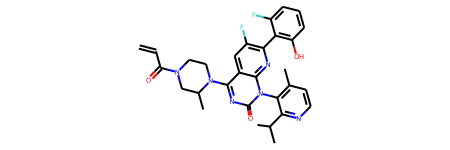

In [373]:
Chem.MolFromSmiles(smiles_amg510)

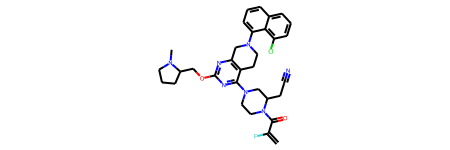

In [374]:
Chem.MolFromSmiles(smiles_mrtx849)

In [375]:
df = pd.DataFrame({'name': ['MRTX849','AMG510'],'smiles': [smiles_mrtx849,smiles_amg510]})

In [376]:
mrtx_dataset = InhibDataset(df,seq=kras_wildtype_seq)
mrtx_dataset_g12c = InhibDataset(df,seq=kras_g12c_seq)

In [377]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(mrtx_dataset)
    df[f'affinity_wt_{i}'] = scale(y_pred.predictions)
df['affinity_wt_mean'] = np.mean([df[f'affinity_wt_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_wt_var'] = np.var([df[f'affinity_wt_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [378]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(mrtx_dataset_g12c)
    df[f'affinity_g12c_{i}'] = scale(y_pred.predictions)
df['affinity_g12c_mean'] = np.mean([df[f'affinity_g12c_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_g12c_var'] = np.var([df[f'affinity_g12c_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


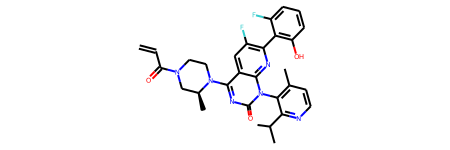

In [380]:
smiles_amg510_sotorasib = 'c1(cc(F)c(c2c(F)cccc2O)n3)c3N(c4c(C)ccnc4C(C)C)C(=O)N=C1N5[C@@H](C)CN(C(=O)C=C)CC5'
smiles_amg510_sotorasib = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_amg510_sotorasib))
Chem.MolFromSmiles(smiles_amg510_sotorasib)

In [381]:
smiles_amg510_sotorasib

'C=CC(=O)N1CCN(c2nc(=O)n(-c3c(C)ccnc3C(C)C)c3nc(-c4c(O)cccc4F)c(F)cc23)[C@@H](C)C1'

In [382]:
df_all = pd.read_parquet('/home/xvg/binding_affinity/data/all_nokras.parquet')

In [441]:
df_all[df_all['seq'].str.upper()!=df_all.seq]

,seq,smiles,affinity_uM,neg_log10_affinity_M,smiles_can,affinity
23547,mgsskskpkdpsqrrcsleppdsthhggfpasqtpnktaapdthrt...,CNC(=O)c1c(SSc2c(C(=O)NC)c3ccccc3n2C)n(C)c2ccc...,6.7,5.173925,CNC(=O)c1c(SSc2c(C(=O)NC)c3ccccc3n2C)n(C)c2ccc...,-0.857520
23548,mgsskskpkdpsqrrcsleppdsthhggfpasqtpnktaapdthrt...,NC(Cc1c(SSc2[nH]c3ccccc3c2CC(N)C(=O)NCc2ccccc2...,1.5,5.823909,NC(Cc1c(SSc2[nH]c3ccccc3c2CC(N)C(=O)NCc2ccccc2...,-0.441240
23549,mgsskskpkdpsqrrcsleppdsthhggfpasqtpnktaapdthrt...,Cn1c([Se][Se]c2c(C(=O)OC(C)(C)C)c3ccccc3n2C)c(...,1.5,5.823909,Cn1c([Se][Se]c2c(C(=O)OC(C)(C)C)c3ccccc3n2C)c(...,-0.441240
23550,mgsskskpkdpsqrrcsleppdsthhggfpasqtpnktaapdthrt...,Cn1c([Se][Se]c2c(C(O)=O)c3ccccc3n2C)c(C(O)=O)c...,2.4,5.619789,Cn1c([Se][Se]c2c(C(=O)O)c3ccccc3n2C)c(C(=O)O)c...,-0.571968
23551,mgsskskpkdpsqrrcsleppdsthhggfpasqtpnktaapdthrt...,CNC(=O)c1c([Se][Se]c2c(C(=O)NC)c3ccccc3n2C)n(C...,0.4,6.397940,CNC(=O)c1c([Se][Se]c2c(C(=O)NC)c3ccccc3n2C)n(C...,-0.073604
...,...,...,...,...,...,...
1908700,mlngenvdsrimgkvatrasskgvkstlgtrgalenisnvarnnlq...,COCCNc1nc(nc2n(cnc12)C(C)C)-c1ccc(NC(=O)OC)cc1,4.4,5.356547,COCCNc1nc(-c2ccc(NC(=O)OC)cc2)nc2c1ncn2C(C)C,-0.740560
1908701,mlngenvdsrimgkvatrasskgvkstlgtrgalenisnvarnnlq...,COCCNc1nc(nc2n(cnc12)C(C)C)-c1ccc(s1)C(C)=O,3.2,5.494850,COCCNc1nc(-c2ccc(C(C)=O)s2)nc2c1ncn2C(C)C,-0.651985
1908702,mlngenvdsrimgkvatrasskgvkstlgtrgalenisnvarnnlq...,COCCNc1nc(nc2n(cnc12)C(C)C)-c1ccc(s1)C#N,2.3,5.638272,COCCNc1nc(-c2ccc(C#N)s2)nc2c1ncn2C(C)C,-0.560131
1908703,mlngenvdsrimgkvatrasskgvkstlgtrgalenisnvarnnlq...,COc1ccc(CNc2nc(nc3n(cnc23)C(C)C)-c2ccc(C=O)cc2...,1.5,5.823909,COc1ccc(CNc2nc(-c3ccc(C=O)cc3)nc3c2ncn3C(C)C)cc1,-0.441240


<AxesSubplot:>

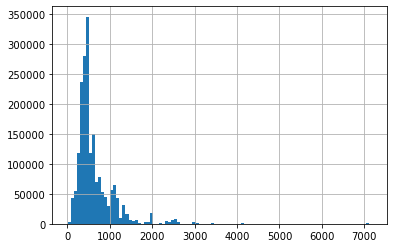

In [104]:
df_all['seq'].str.len().hist(bins=100)

**Satorasib series**

In [228]:
df = pd.read_csv('/home/xvg/jm9b01180_si_002.csv',encoding_errors='ignore')
df['smiles_can'] = df['SMILES'].apply(lambda smi: Chem.MolToSmiles(Chem.MolFromSmiles(smi)))

In [229]:
# 169 residues
kras_wildtype_seq = 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLK'
# 189 residues
kras_wildtype_seq = 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHHYREQIKRVKDSEDVPMVLVGNKCDLPSRTVDTKQAQDLARSYGIPFIETSAKTRQRVEDAFYTLVREIRQYRLKKISKEEKTPGCVKIKKCIIM'

kras_g12c_seq = kras_wildtype_seq[:11]+"C"+kras_wildtype_seq[12:]
kras_g12d_seq = kras_wildtype_seq[:11]+"D"+kras_wildtype_seq[12:]
kras_g12v_seq = kras_wildtype_seq[:11]+"V"+kras_wildtype_seq[12:]

kras_wildtype_dataset_sotorasib = InhibDataset(df,seq=kras_wildtype_seq,smiles_name='SMILES')
kras_g12c_dataset_sotorasib = InhibDataset(df,seq=kras_g12c_seq,smiles_name='SMILES')
kras_g12d_dataset_sotorasib = InhibDataset(df,seq=kras_g12d_seq,smiles_name='SMILES')
kras_g12v_dataset_sotorasib = InhibDataset(df,seq=kras_g12v_seq,smiles_name='SMILES')

In [230]:
n = len(model_files)
for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_wildtype_dataset_sotorasib)
    df[f'affinity_wt_{i}'] = scale(y_pred.predictions)
df['affinity_wt_mean'] = np.mean([df[f'affinity_wt_{i}'] for i in range(n)],axis=0)
df['affinity_wt_var'] = np.var([df[f'affinity_wt_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


In [231]:
n = len(model_files)
for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_g12c_dataset_sotorasib)
    df[f'affinity_g12c_{i}'] = scale(y_pred.predictions)
df['affinity_g12c_mean'] = np.mean([df[f'affinity_g12c_{i}'] for i in range(n)],axis=0)
df['affinity_g12c_var'] = np.var([df[f'affinity_g12c_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


In [232]:
n = len(model_files)
for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_g12d_dataset_sotorasib)
    df[f'affinity_g12d_{i}'] = scale(y_pred.predictions)
df['affinity_g12d_mean'] = np.mean([df[f'affinity_g12d_{i}'] for i in range(n)],axis=0)
df['affinity_g12d_var'] = np.var([df[f'affinity_g12d_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


In [233]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_g12v_dataset_sotorasib)
    df[f'affinity_g12v_{i}'] = scale(y_pred.predictions)
df['affinity_g12v_mean'] = np.mean([df[f'affinity_g12v_{i}'] for i in range(n)],axis=0)
df['affinity_g12v_var'] = np.var([df[f'affinity_g12v_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


In [234]:
col_name_exchange = df.columns[2]

In [235]:
(df['affinity_g12v_mean']-df['affinity_wt_mean']).abs().max()

0.04768607987540374

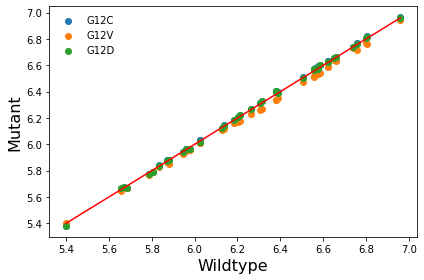

In [238]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = df['affinity_wt_mean']
y = df['affinity_g12c_mean']
ax.scatter(x,y,label='G12C')


x = df['affinity_wt_mean']
y = df['affinity_g12v_mean']
ax.scatter(x,y,label='G12V')

x = df['affinity_wt_mean']
y = df['affinity_g12d_mean']
ax.scatter(x,y,label='G12D')

x = np.linspace(x.min(),x.max(),2)
y = x
ax.plot(x,y,'r')
ax.set_xlabel('Wildtype',fontsize=16)
ax.set_ylabel('Mutant',fontsize=16)
ax.legend(frameon=False)
fig.tight_layout()
#fig.savefig('kras_wt_vsg12v.png',dpi=300)

In [239]:
(df['affinity_wt_mean']-df['affinity_g12c_mean']).min()

-0.02047754182309891

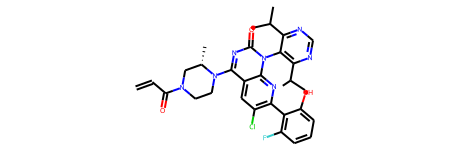

In [240]:
Chem.MolFromSmiles(df.iloc[(df['affinity_wt_mean']-df['affinity_g12c_mean']).argmin()].SMILES)

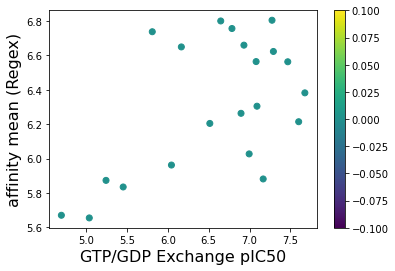

In [241]:
fig, ax = plt.subplots()
x = 6-np.log10(df[col_name_exchange])
y = df['affinity_wt_mean']
z = df['affinity_wt_var']
ax.set_xlabel('GTP/GDP Exchange pIC50',fontsize=16)
ax.set_ylabel('affinity mean (Regex)',fontsize=16)
p = ax.scatter(x,y,c=z)
fig.colorbar(p)
fig.savefig('sotorasib_series_nokras.png',dpi=300)

In [242]:
from scipy.stats import spearmanr
x = 6-np.log10(df[col_name_exchange])
y = df['affinity_wt_mean']
y = y[~x.isna()]
x = x[~x.isna()]
spearmanr(x,y)

SpearmanrResult(correlation=0.40389610389610386, pvalue=0.06939949544788356)

**KRAS library**

In [335]:
with Chem.SDMolSupplier('/home/xvg/KRAS_15997.sdf') as suppl:
    ms = [x for x in suppl]

In [336]:
names = [m.GetProp('IDNUMBER') for m in ms]
chem_names = [m.GetProp('CHEMNAME') for m in ms]
smiles = [m.GetProp('SMILE') for m in ms]

In [337]:
df = pd.DataFrame({'name': names, 'chem_name': chem_names, 'smiles': smiles})

In [338]:
kras_wildtype_dataset_lib = InhibDataset(df,seq=kras_wildtype_seq,smiles_name='smiles')
kras_g12c_dataset_lib = InhibDataset(df,seq=kras_g12c_seq,smiles_name='smiles')
kras_g12v_dataset_lib = InhibDataset(df,seq=kras_g12v_seq,smiles_name='smiles')

In [339]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_wildtype_dataset_lib)
    df[f'affinity_wt_{i}'] = scale(y_pred.predictions)
df['affinity_wt_mean'] = np.mean([df[f'affinity_wt_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_wt_var'] = np.var([df[f'affinity_wt_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [340]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_g12v_dataset_lib)
    df[f'affinity_g12v_{i}'] = scale(y_pred.predictions)
df['affinity_g12v_mean'] = np.mean([df[f'affinity_g12v_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_g12v_var'] = np.var([df[f'affinity_g12v_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [341]:
for i in range(len(model_files)):
    load_ensemble(i)
    y_pred=trainer.predict(kras_g12c_dataset_lib)
    df[f'affinity_g12c_{i}'] = scale(y_pred.predictions)
df['affinity_g12c_mean'] = np.mean([df[f'affinity_g12c_{i}'] for i in range(len(model_files))],axis=0)
df['affinity_g12c_var'] = np.var([df[f'affinity_g12c_{i}'] for i in range(len(model_files))],axis=0)

Tokenizer lower_case: False
Tokenizer lower_case: False


In [408]:
#df.to_csv('/home/xvg/kras_library.csv')
df = pd.read_csv('/home/xvg/kras_library.csv')

In [409]:
df_library = df

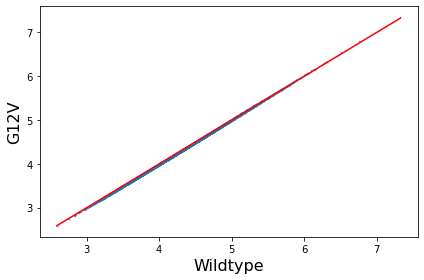

In [385]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = df['affinity_wt_mean']
y = df['affinity_g12v_mean']
ax.scatter(x,y,s=0.1)
x = np.linspace(x.min(),x.max(),2)
y = x
ax.plot(x,y,'r')
ax.set_xlabel('Wildtype',fontsize=16)
ax.set_ylabel('G12V',fontsize=16)
fig.tight_layout()

In [410]:
(df['affinity_wt_mean']-df['affinity_g12c_mean']).min()

-0.12566666841405905

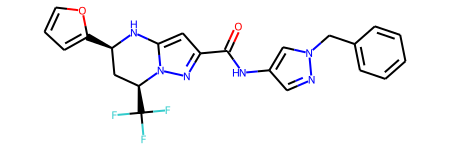

In [386]:
Chem.MolFromSmiles(df.iloc[(df['affinity_wt_mean']-df['affinity_g12c_mean']).argmin()].smiles)

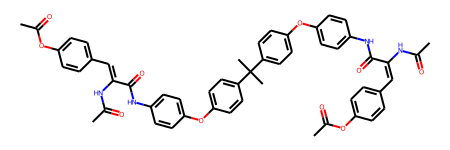

In [387]:
Chem.MolFromSmiles(df.iloc[df['affinity_g12c_mean'].argmax()].smiles)

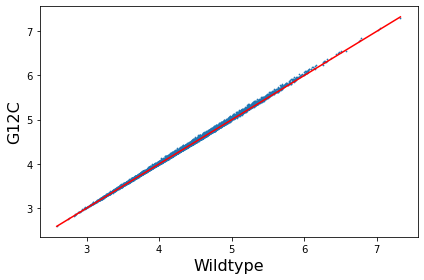

In [389]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = df['affinity_wt_mean']
y = df['affinity_g12c_mean']
ax.scatter(x,y,s=0.5)
x = np.linspace(x.min(),x.max(),2)
y = x
ax.plot(x,y,'r')
ax.set_xlabel('Wildtype',fontsize=16)
ax.set_ylabel('G12C',fontsize=16)
# ax.set_xlim(6,None)
# ax.set_ylim(6,None)
fig.tight_layout()

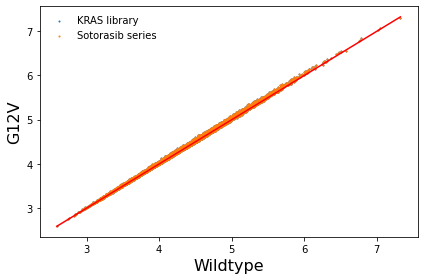

In [346]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

df_select = df#_library[df_library['affinity_wt_mean'] > 6]
x = df_select['affinity_wt_mean']
y = df_select['affinity_g12c_mean']
ax.scatter(x,y,label='KRAS library',s=1)

x = np.linspace(x.min(),x.max(),2)
y = x
ax.plot(x,y,'r')

x = df['affinity_wt_mean']
y = df['affinity_g12c_mean']
ax.scatter(x,y,label='Sotorasib series',s=1)

ax.legend(frameon=False)
ax.set_xlabel('Wildtype',fontsize=16)
ax.set_ylabel('G12V',fontsize=16)
fig.tight_layout()

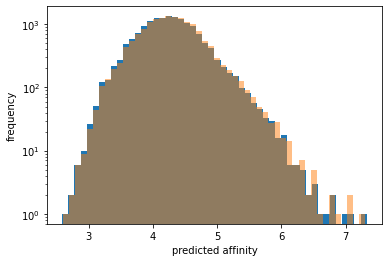

In [349]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = df['affinity_wt_mean']
ax.hist(x,bins=50)
x = df['affinity_g12c_mean']
ax.hist(x,bins=50,alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel('predicted affinity')
ax.set_ylabel('frequency')
ax.get_figure().savefig('/home/xvg/hist_ic50.png',dpi=300)

In [350]:
df.sort_values(by='affinity_wt_mean',ascending=False)

,Unnamed: 0,name,chem_name,smiles,affinity_wt_0,affinity_wt_mean,affinity_wt_var,affinity_g12v_0,affinity_g12v_mean,affinity_g12v_var,affinity_g12c_0,affinity_g12c_mean,affinity_g12c_var
9996,9996,8002-6009,4-[(1Z)-2-[(4-{4-[2-(4-{4-[(2E)-3-[4-(ACETYLOX...,CC(C)(c(cc1)ccc1Oc(cc1)ccc1NC(/C(/NC(C)=O)=C\c...,7.325849,7.325849,0.0,7.353957,7.353957,0.0,7.301580,7.301580,0.0
1087,1087,8010-1065,"5-[6-(5,6-DICYANO-3-PHENYLPYRAZIN-2-YL)-9-OXO-...",N#Cc1c(C#N)nc(-c(cc2)cc(-c3c4ccc(-c5nc(C#N)c(C...,7.046332,7.046332,0.0,7.060570,7.060570,0.0,7.085432,7.085432,0.0
300,300,K204-0003,"N-[(1E)-1-{N'-[(E)-[3A,5A,7-TRIHYDROXY-11A-MET...",CCc1ccc(/C=C(\C(N/N=C/C(CC[C@H](C2)O)([C@@H](C...,7.017613,7.017613,0.0,7.037972,7.037972,0.0,7.024208,7.024208,0.0
7931,7931,S952-0132,"8-[4-CYANO-3-(TRIFLUOROMETHYL)PHENYL]-N-(3,5-D...",Cc1cc(NC(N(C2)CC(CC3)(CCN3c(cc3)cc(C(F)(F)F)c3...,6.777672,6.777672,0.0,6.803624,6.803624,0.0,6.839957,6.839957,0.0
11079,11079,K781-0934,N-[2-(METHYLSULFANYL)PHENYL]-4-{6-OXO-711-DIAZ...,CSc(cccc1)c1NC(c(cc1)cc(NC(/C=C/c2ccccc2)=O)c1...,6.762759,6.762759,0.0,6.783735,6.783735,0.0,6.799824,6.799824,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10154,10154,F327-0274,"N-CYCLOHEXYL-7,11-DIAZASPIRO[5.6]DODEC-11-EN-1...",C(CC1)CCC1NC1=NCCCNC11CCCCC1,2.833790,2.833790,0.0,2.815321,2.815321,0.0,2.839565,2.839565,0.0
10554,10554,T001-1290,N-[2-(5-METHYL-1H-INDOL-3-YL)ETHYL]ACRYLAMIDE,Cc(cc1)cc2c1[nH]cc2CCNC(C=C)=O,2.828414,2.828414,0.0,2.805738,2.805738,0.0,2.830564,2.830564,0.0
1645,1645,D443-0135,N-(2-HYDROXYETHYL)-1-BENZOXEPINE-4-CARBOXAMIDE,OCCNC(C1=Cc(cccc2)c2OC=C1)=O,2.753823,2.753823,0.0,2.733661,2.733661,0.0,2.772320,2.772320,0.0
12505,12505,Y032-1078,(E)-1-(2-METHYLPIPERIDINO)-3-PHENYL-2-PROPEN-1...,CC(CCCC1)N1C(/C=C/c1ccccc1)=O,2.742545,2.742545,0.0,2.730970,2.730970,0.0,2.745198,2.745198,0.0


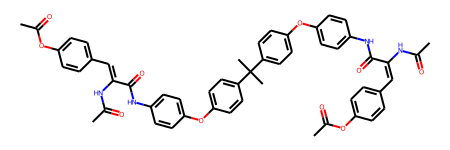

In [351]:
smi = df.sort_values(by='affinity_wt_mean',ascending=False).reset_index(drop=False).iloc[0]['smiles']
mol = Chem.MolFromSmiles(smi)
smi = Chem.MolToSmiles(mol)
mol

/home/xvg/miniconda3/envs/affinity/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


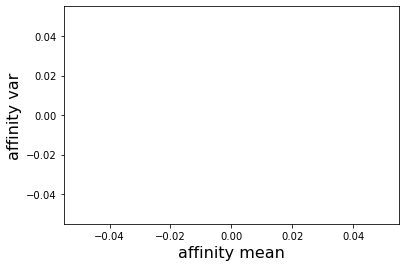

In [352]:
fig, ax = plt.subplots()
x = df['affinity_wt_mean']
y = np.log(df['affinity_wt_var'])
ax.set_xlabel('affinity mean',fontsize=16)
ax.set_ylabel('affinity var',fontsize=16)
ax.scatter(x,y,s=.1)
fig.savefig('kras_library_series.png',dpi=300)

In [353]:
df.head()

,Unnamed: 0,name,chem_name,smiles,affinity_wt_0,affinity_wt_mean,affinity_wt_var,affinity_g12v_0,affinity_g12v_mean,affinity_g12v_var,affinity_g12c_0,affinity_g12c_mean,affinity_g12c_var
0,0,T408-0175,"N5-(2,5-DIFLUOROPHENYL)-N2,N2-DIETHYL-4,5,6,7-...",CCN(CC)C(c1cc(CC(CC2)C(Nc(cc(cc3)F)c3F)=O)c2s1)=O,3.940378,3.940378,0.0,3.928727,3.928727,0.0,3.975064,3.975064,0.0
1,1,D165-0209,"4-[2-(4-TERT-BUTYLPHENYL)-1H-NAPHTHO[1,2-F][1,...",CC(C)(C)c(cc1)ccc1C1=NC(c2ccncc2)=Nc(ccc2ccccc...,5.087350,5.087350,0.0,5.101811,5.101811,0.0,5.095510,5.095510,0.0
2,2,8015-3643,"N-CYANO-4,6-BIS(PIPERIDIN-1-YL)-N-(PROP-2-EN-1...",C=CCN(c1nc(N2CCCCC2)nc(N2CCCCC2)n1)C#N,4.131747,4.131747,0.0,4.122664,4.122664,0.0,4.133771,4.133771,0.0
3,3,K832-4232,"7-(4-BROMOPHENYL)-5-(4-IODOPHENYL)-4H,5H,6H,7H...",Brc1ccc([C@H](C2)n3ncnc3N[C@H]2c(cc2)ccc2I)cc1,4.076071,4.076071,0.0,4.079904,4.079904,0.0,4.094089,4.094089,0.0
4,4,4285-1884,4-[(4Z)-4-{[5-(2-CHLORO-5-NITROPHENYL)FURAN-2-...,CC(/C(/C1=O)=C/c2ccc(-c(cc(cc3)[N+]([O-])=O)c3...,4.705652,4.705652,0.0,4.696891,4.696891,0.0,4.722431,4.722431,0.0


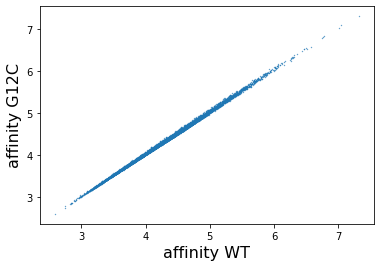

In [354]:
fig, ax = plt.subplots()
x = df['affinity_wt_mean']
y = df['affinity_g12c_mean']
ax.set_xlabel('affinity WT',fontsize=16)
ax.set_ylabel('affinity G12C',fontsize=16)
ax.scatter(x,y,s=.1)
#fig.savefig('kras_library_series.png',dpi=300)

**Pfizer Mpro**

In [81]:
# PF-07321332
smi_pf07321332 = '[H][C@]12CN([C@H](C(=O)N[C@@H](C[C@]3([H])CCNC3=O)C#N)[C@@]1([H])C2(C)C)C(=O)[C@@H](NC(=O)C(F)(F)F)C(C)(C)C'
smi_pf07304814 = 'CC(C)CC(C(=O)NC(CC1CCNC1=O)C(=O)COP(=O)(O)O)NC(=O)C2=CC3=C(N2)C=CC=C3OC'

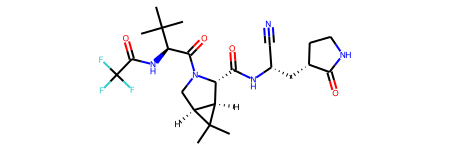

In [82]:
Chem.MolFromSmiles(smi_pf07321332)

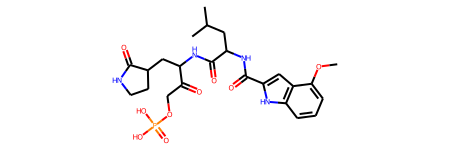

In [83]:
Chem.MolFromSmiles(smi_pf07304814)

In [84]:
df = pd.DataFrame({'name': ['PF-07321332','PF-07304814'],'smiles': [smi_pf07321332,smi_pf07304814]})

In [85]:
pfizer_dataset = InhibDataset(df,seq=mpro_seq_uniprot, smiles_name='smiles')

In [86]:
n = len(model_files)


for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(pfizer_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


In [87]:
df[['name','affinity_mean','affinity_var']]

,name,affinity_mean,affinity_var
0,PF-07321332,5.321681,0.0
1,PF-07304814,6.945795,0.0


**Ondansetron**

In [88]:
from rdkit import Chem
smi_ondansetron = Chem.MolToSmiles(Chem.MolFromSmiles('CC1=NC=CN1CC2CCC3=C(C2=O)C4=CC=CC=C4N3C'))

In [89]:
df = df_virus.copy()

In [90]:
ondansetron_dataset = ProteinDataset(df,smiles=smi_ondansetron, seq_name='seq')

In [91]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(ondansetron_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


<BarContainer object of 38 artists>

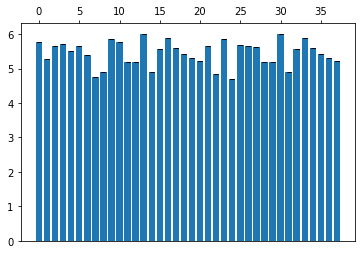

In [92]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y = df['affinity_mean'].values
yerr = np.sqrt(df['affinity_var'].values/n)
ax.xaxis.tick_top()

ax.bar(x=np.arange(len(y)),height=y, yerr=yerr,capsize=2)

In [93]:
df['seqlen'] = df['seq'].str.len()
df.sort_values(by='affinity_mean',ascending=False).head()

,id,seq,description,affinity_0,affinity_mean,affinity_var,seqlen
30,YP_009742610.1,APTKVTFGDDTVIEVQGYKSVNITFELDERIDKVLNEKCSAYTVEL...,YP_009742610.1 nsp3 [polyprotein_range=YP_0097...,6.009736,6.009736,0.0,1945
13,YP_009725299.1,APTKVTFGDDTVIEVQGYKSVNITFELDERIDKVLNEKCSAYTVEL...,YP_009725299.1 nsp3 [polyprotein_range=YP_0097...,6.009736,6.009736,0.0,1945
33,YP_009742613.1,SAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFA...,YP_009742613.1 nsp6 [polyprotein_range=YP_0097...,5.885166,5.885166,0.0,290
16,YP_009725302.1,SAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFA...,YP_009725302.1 nsp6 [polyprotein_range=YP_0097...,5.885166,5.885166,0.0,290
23,YP_009725309.1,AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...,YP_009725309.1 3'-to-5' exonuclease [polyprote...,5.864544,5.864544,0.0,527


In [94]:
df = df_virus.copy()

In [95]:
pfizer_dataset = ProteinDataset(df,smiles=smi_pf07321332, seq_name='seq')

In [96]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(pfizer_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


<BarContainer object of 38 artists>

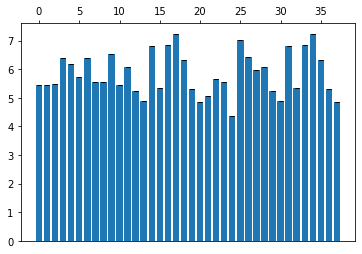

In [97]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y = df['affinity_mean'].values
yerr = np.sqrt(df['affinity_var'].values/n)
idx = np.argsort(y)[::-1]
#y = y[idx]
#yerr = yerr[idx]
ax.xaxis.tick_top()

ax.bar(x=np.arange(len(y)),height=y, yerr=yerr,capsize=2)
#fig.savefig('pfizer_pf07321332_no_sentencepair.png',dpi=300)

In [98]:
df['seqlen'] = df['seq'].str.len()
df.sort_values(by='affinity_mean',ascending=False).head(8)

,id,seq,description,affinity_0,affinity_mean,affinity_var,seqlen
34,YP_009742614.1,SKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTT...,YP_009742614.1 nsp7 [polyprotein_range=YP_0097...,7.241509,7.241509,0.0,83
17,YP_009725303.1,SKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTT...,YP_009725303.1 nsp7 [polyprotein_range=YP_0097...,7.241509,7.241509,0.0,83
25,YP_009725311.1,SSQAWQPGVAMPNLYKMQRMLLEKCDLQNYGDSATLPKGIMMNVAK...,YP_009725311.1 2'-O-ribose methyltransferase [...,7.029100,7.029100,0.0,298
16,YP_009725302.1,SAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFA...,YP_009725302.1 nsp6 [polyprotein_range=YP_0097...,6.860820,6.860820,0.0,290
33,YP_009742613.1,SAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFA...,YP_009742613.1 nsp6 [polyprotein_range=YP_0097...,6.860820,6.860820,0.0,290
14,YP_009725300.1,KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...,YP_009725300.1 nsp4 [polyprotein_range=YP_0097...,6.821334,6.821334,0.0,500
31,YP_009742611.1,KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...,YP_009742611.1 nsp4 [polyprotein_range=YP_0097...,6.821334,6.821334,0.0,500
9,YP_009725255.1:1-38,MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT,YP_009725255.1:1-38 ORF10 protein [organism=Se...,6.539898,6.539898,0.0,38


In [100]:
smi_39 = Chem.MolToSmiles(Chem.MolFromSmiles(df_order[df_order.ID==cpd_39].iloc[0].Smile))
smi_37 = Chem.MolToSmiles(Chem.MolFromSmiles(df_order[df_order.ID==cpd_37].iloc[0].Smile))

In [101]:
#filt =~df_virus.description.str.contains('ORF') | df_virus['description'].str.contains('range')
#filt &= (df_virus['seq'].str.len() < max_seq_length)

In [102]:
#df = df_virus[filt].copy().reset_index(drop=True)
df = df_virus.copy()

#cpd_dataset = ProteinDataset(df,smiles='O=C(CC1=CC(Cl)=CC=C1)NC1=CN=CC2=CC=CC=C12', seq_name='seq')
#cpd_dataset = ProteinDataset(df,smiles='O=C(Nc1cncc2ccc(F)cc12)[C@H]1CCOc2cc(F)c(Cl)cc21', seq_name='seq')
cpd_dataset = ProteinDataset(df,smiles=smi_39, seq_name='seq')

In [103]:
n = len(model_files)
for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(cpd_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_sem'] = np.sqrt(df['affinity_var']/n)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


In [104]:
#df.sort_values(by='affinity_mean',ascending=False).head()
df['seqlen'] = df['seq'].str.len()
df.sort_values(by='affinity_mean',ascending=False).head()

,id,seq,description,affinity_0,affinity_mean,affinity_var,affinity_sem,seqlen
23,YP_009725309.1,AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...,YP_009725309.1 3'-to-5' exonuclease [polyprote...,7.107606,7.107606,0.0,0.0,527
21,YP_009725307.1,SADAQSFLNRVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFA...,YP_009725307.1 RNA-dependent RNA polymerase [p...,7.015302,7.015302,0.0,0.0,932
32,YP_009742612.1,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,YP_009742612.1 3C-like proteinase [polyprotein...,6.970830,6.970830,0.0,0.0,306
15,YP_009725301.1,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,YP_009725301.1 3C-like proteinase [polyprotein...,6.970830,6.970830,0.0,0.0,306
5,YP_009724394.1:1-61,MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...,YP_009724394.1:1-61 ORF6 protein [organism=Sev...,6.947451,6.947451,0.0,0.0,61


<BarContainer object of 38 artists>

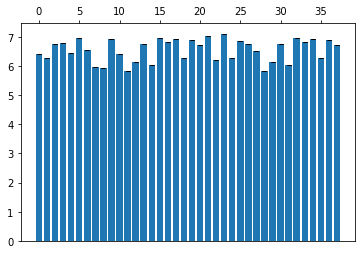

In [105]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y = df['affinity_mean'].values
yerr = df['affinity_sem'].values
idx = np.argsort(y)[::-1]
#y = y[idx]
#yerr = yerr[idx]
ax.xaxis.tick_top()

ax.bar(x=np.arange(len(y)),height=y, yerr=yerr,capsize=2)

**Postera Mpro**

In [24]:
# df['pIC50'] = 6-np.log10(np.sqrt(df['f_avg_IC50']*df['r_avg_IC50']))
# df = df[~df['pIC50'].isna()]

In [25]:
df = pd.read_csv('/home/xvg/activity_data.csv')
#df = df[~df['f_avg_IC50'].isnull()].copy().reset_index(drop=True)

In [26]:
postera_dataset = InhibDataset(df=df, smiles_name='SMILES', seq=mpro_seq_uniprot)

In [27]:
# y_pred=trainer.predict(postera_dataset)
# df['affinity_mean'] = scale(y_pred.predictions)
##df['affinity_var'] = scale_var(y_pred.predictions[:,1])

In [ ]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(postera_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

In [33]:
# uncomment to load paper results

#df.to_parquet(f'postera.parquet')
#df = pd.read_parquet(f'postera.parquet')

In [34]:
df.sort_values(by='affinity_mean',ascending=False)

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,...,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id,affinity_0,affinity_mean,affinity_var
417,O=C(CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)...,EDG-MED-ba1ac7b9-11,EDG-MED-ba1ac7b9-11,NaN,NaN,NaN,NaN,NaN,0.502722,NaN,...,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,8.048105,8.048105,0.0
121,Cn1cc(N2CCC(CNCC3(C(=O)Nc4cncc5ccccc45)CCOc4cc...,MAT-POS-5f1400cf-1,MAT-POS-5f1400cf-1,NaN,NaN,NaN,NaN,NaN,5.374548,NaN,...,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,8.036552,8.036552,0.0
429,CC1CN(C(=O)CC2(C(=O)Nc3cncc4ccccc34)CCOc3ccc(C...,EDG-MED-ba1ac7b9-25,EDG-MED-ba1ac7b9-25,NaN,NaN,NaN,NaN,NaN,99.500000,NaN,...,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,8.015963,8.015963,0.0
355,N#CCCN1CCN(C(=O)CC2(C(=O)Nc3cncc4ccccc34)CCOc3...,ALP-UNI-8e43a71e-7,ALP-UNI-8e43a71e-7,NaN,NaN,NaN,NaN,NaN,21.301593,NaN,...,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,7.935852,7.935852,0.0
418,O=C(CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)...,EDG-MED-ba1ac7b9-12,EDG-MED-ba1ac7b9-12,NaN,NaN,NaN,NaN,NaN,7.978041,NaN,...,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,7.934511,7.934511,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,N#C/C(C(=O)Nc1ccc(F)cc1)=C(/O)c1ccc(Cl)cc1,JOH-UNI-c7afdb96-2,JOH-UNI-c7afdb96-2,NaN,NaN,0.233603,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,NaN,3.919657,3.919657,0.0
308,C#CCCCC(=O)N[C@H](C(=O)N[C@H](CC(C)C)C(=O)NN(C...,STE-KUL-d79e3d6a-2,STE-KUL-d79e3d6a-2,NaN,NaN,NaN,NaN,NaN,0.044004,NaN,...,NaN,NaN,NaN,False,False,Ugi,NaN,3.857885,3.857885,0.0
1009,Nc1n[nH]c2cc(O)nc(O)c12,LON-WEI-4d77710c-62,LON-WEI-4d77710c-62,NaN,NaN,99.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,NaN,3.844570,3.844570,0.0
1397,CCP(CC)(CC)=[Au]S[C@@H]1O[C@H](COC(C)=O)[C@@H]...,JOH-UNI-44664832-2,JOH-UNI-44664832-2,NaN,NaN,1.240614,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,NaN,3.660592,3.660592,0.0


In [35]:
from scipy.stats import spearmanr
field = 'f_avg_IC50'
filt = ~df[field].isnull()
x = df[filt]['affinity_mean']
y = 6-np.log10(df[filt][field])
spearmanr(x,y)

SpearmanrResult(correlation=0.25192343727039535, pvalue=3.328522834162265e-21)

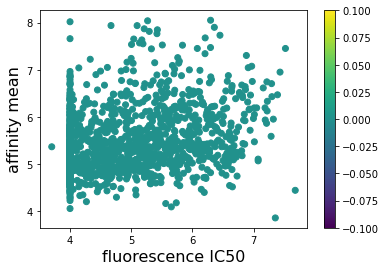

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
field = 'f_avg_IC50'
filt = ~df[field].isnull()
x = 6-np.log10(df[filt][field])
y = df[filt]['affinity_mean']
z = df[filt]['affinity_var']
ax.set_xlabel('fluorescence IC50',fontsize=16)
ax.set_ylabel('affinity mean',fontsize=16)
p = ax.scatter(x,y,c=z)
fig.colorbar(p)

In [37]:
from scipy.stats import spearmanr, pearsonr

nbootstrap = 500
samplesize = len(df)

field = 'f_avg_IC50'
sp = []
pr = []
mse = []
filt = ~df[field].isnull()
#filt = df[field] < 10
for i in range(nbootstrap):
    df_sample = df[filt].sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'])
    #samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    samples = df_sample['affinity_mean']
    x = samples
    y = 6-np.log10(df_sample[field])

    import pickle
    s = spearmanr(x,y)
    sp.append(s.correlation)    
    pr.append(pearsonr(x,y)[0])
    mse.append(mean_squared_error(y,x))

#pickle.dump([np.mean(sp),np.std(sp)],open(f'postera_spearmanr_{tokenizer_type}.p','wb'))
print(np.mean(sp), np.std(sp))
print(np.mean(pr), np.std(pr))
print(np.mean(mse), np.std(mse))

0.24980869652917279 0.024979647090348545
0.25363058455352383 0.025111292136334774
1.2965724747435448 0.04219846119740806


In [38]:
df.columns

Index(['SMILES', 'CID', 'canonical_CID', 'r_inhibition_at_20_uM',
       'r_inhibition_at_50_uM', 'r_avg_IC50', 'f_inhibition_at_20_uM',
       'f_inhibition_at_50_uM', 'f_avg_IC50', 'f_avg_pIC50',
       'relative_solubility_at_20_uM', 'relative_solubility_at_100_uM',
       'trypsin_IC50', 'NMR_std_ratio', 'acrylamide', 'chloroacetamide',
       'series', 'frag_id', 'affinity_0', 'affinity_mean', 'affinity_var'],
      dtype='object')

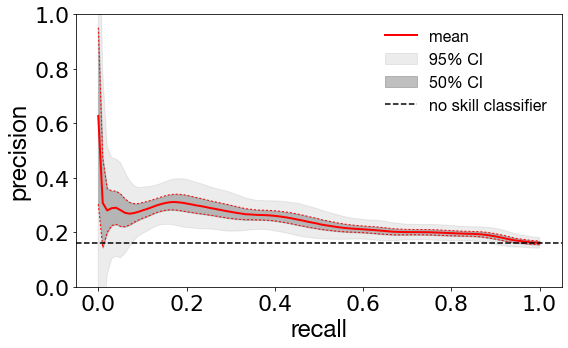

In [39]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = 1
nbootstrap = 2500

x = np.linspace(0,1,100)
field = 'f_avg_IC50'

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
df_select = df[~df[field].isnull()]

samplesize = len(df_select)

ps = []
np.random.seed(42)
for i in range(nbootstrap):
    df_sample = df_select.sample(n=samplesize,replace=True) 
    yr = df_sample[field] < thresh
    #samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    samples = df_sample['affinity_mean']
    p, r, _ = precision_recall_curve(yr,samples)#,sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
#     if i % 100 == 0:
#         ax.plot(r,p,'-',color='b',alpha=1,lw=.5)
    #r, p, _ = roc_curve(yr, df_sample.prediction)
    #ps.append(np.interp(x,r,p))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))
ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='upper right')
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

# ax2 = ax.inset_axes(bounds=(0.6,0.6,0.4,0.4))
# df_select = df#[df['f_avg_IC50']<90]
# y = 6-np.log(df_select['f_avg_IC50'])/np.log(10)
# x = df_select['affinity_mean']
# c = -np.log(df_select['affinity_var'])
# ax2.scatter(x,y,c=c)
# res = linregress(x,y)
# xfit = np.linspace(x.min(),x.max(),2)
# ax2.plot(xfit,res.intercept + res.slope*xfit, 'r', label=f"{res.slope :.2f}*x+{res.intercept:.2f}")
# ax2.set_ylabel('experimental pIC50',fontsize=14)
# ax2.set_xlabel('predicted pIC50',fontsize=14)
# ax2.legend(frameon=False)
# ax2.tick_params(labelsize=16)

# df_select = df[df['f_avg_IC50'] < thresh]
# ax2.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=25,alpha=0.5,zorder=2,lw=0.5,edgecolor='k')
# df_select = df[df['f_avg_IC50'] >= thresh]
# ax2.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=25,alpha=0.5,zorder=1,lw=0.5,edgecolor='k')
# ax2.set_xlabel('-log[Affinity] $\mu$',fontsize=22)
# ax2.set_ylabel('log $\sigma^2$',fontsize=22)
# ax2.axvline(6-np.log(thresh)/np.log(10),dashes=[1,1])

fig.tight_layout()
fig.savefig('mpro_new.png',dpi=300)
# fig.savefig('mpro_new_pretrain.pdf')
# fig.savefig('mpro_new_pretrain.svg')

In [29]:
#import importlib
#del EnsembleExplainer
#importlib.reload(explain)

In [30]:
import explain
from explain import EnsembleExplainer

In [31]:
idx = df[df['CID'].str.startswith('ADA-UCB-6c2cb422-1')].index[0]
inhib_dataset = InhibDataset(df=df, smiles_name='SMILES', seq=mpro_seq_uniprot, padding='longest')

In [32]:
trainer.model.eval()
explainer = EnsembleExplainer(trainer.model)

In [33]:
loader = torch.utils.data.DataLoader([inhib_dataset[idx]],batch_size=1)

In [34]:
%%time 
item = next(iter(loader))

device = torch.device("cuda:0")                
input_ids_1 = item['input_ids_1'].to(device)
input_ids_2 = item['input_ids_2'].to(device)
attention_mask_1 = item['attention_mask_1'].to(device)
attention_mask_2 = item['attention_mask_2'].to(device)

with torch.autocast('cuda'):
    interactions = explainer(
        input_ids_1=input_ids_1,
        input_ids_2=input_ids_2,
        attention_mask_1=attention_mask_1,
        attention_mask_2=attention_mask_2,
        output_indices=0, # (0,0) = mean, (0,1) = variance
        num_samples=2,
        use_expectation=False,
        return_attributions=False,
        batch_size=1, # > 1 gives weird results
    )

CPU times: user 2min 39s, sys: 4.12 s, total: 2min 43s
Wall time: 2min 37s


In [67]:
import pickle
with open('interactions.p','wb') as f:
    pickle.dump(interactions,f)

In [72]:
import pickle
with open('interactions.p','rb') as f:
    interactions = pickle.load(f)

In [35]:
%matplotlib widget

In [48]:
import matplotlib.pyplot as plt

X = interactions[0] #> 0.00125
fig, ax = plt.subplots()
fig.set_size_inches(9,6)

seq_len = len(input_ids_1[0])
ax.axhline(seq_len,color='k')
ax.axvline(seq_len,color='k')

p = ax.imshow(X,interpolation='none',cmap='bwr')
p.set_clim(-10,10)
fig.colorbar(p)
fig.savefig('interactions_ada_ucb_dense.png',dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

**Hit expansion**

In [40]:
df = pd.read_csv('/home/xvg/exp_merge.csv')
df['% residual activity'] = df['% residual activity'].str.split('%').str[0].astype('float32')
#df = df[df['SMILES_fp'].notnull() | df['SMILES_map4'].notnull()].reset_index()

df_rescreen = pd.read_csv('/home/xvg/20210614__Expt111_112_113Glaser_SedovaEnaminecmpddata.csv')
df_rescreen['res_activity_percent_confirmation'] = df_rescreen['% residual activity']*100
df = df_rescreen.merge(df,left_on='inhibitor',right_on='Inhibitor')
df = df[df['SMILES_map4'].notnull()].reset_index()
df['z-score_gmean'] = np.sqrt(df['z-score_x']*df['z-score_y'])
df['z-score_mean'] = 0.5*(df['z-score_x']+df['z-score_y'])
df = df[~df['z-score_gmean'].isna()].reset_index(drop=True)

In [41]:
hit_expansion_dataset = InhibDataset(df,smiles_name='SMILES_map4',seq=mpro_seq_uniprot)

In [42]:
# y_pred=trainer.predict(hit_expansion_dataset)
# df['affinity_mean'] = scale(y_pred.predictions)
# #df['affinity_var'] = scale_var(y_pred.predictions[:,1])

In [43]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(hit_expansion_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


In [44]:
from scipy.stats import spearmanr, pearsonr

nbootstrap = 500
samplesize = len(df)
primary = True

sp = []
mse = []
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'])
    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    #samples = df_sample['affinity_mean']
    x = samples
    #y = df_sample['z-score_{}'.format('x' if primary else 'y')]
    y = df_sample['z-score_gmean']

    import pickle
    s = spearmanr(x,y)
    sp.append(s.correlation)    
    mse.append(mean_squared_error(y,x))

#pickle.dump([np.mean(sp),np.std(sp)],open(f'hitexpansion_spearmanr_{tokenizer_type}.p','wb'))
print(np.mean(sp), np.std(sp))

0.23665052831611263 0.13023953574852448


In [45]:
from scipy.stats import spearmanr

x = df['affinity_mean']
#x = -df['affinity_var']

#y = df['z-score_{}'.format('x' if primary else 'y')]
y = df['z-score_gmean']

#x = x[y>6]
#y = y[y>6]
import pickle
s = spearmanr(x,y)
#pickle.dump(s,open('hitexpansion_{}_spearmanr_{}.p'.format('primary' if primary else 'confirmation',tokenizer_type),'wb'))
spearmanr(x,y)

SpearmanrResult(correlation=0.24665827950472552, pvalue=0.06946042659120776)

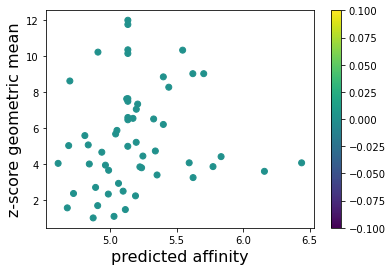

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y = df['z-score_gmean']
x = df['affinity_mean']
z = df['affinity_var']
p = ax.scatter(x,y,c=z)
ax.set_xlabel('predicted affinity',fontsize=16)
ax.set_ylabel('z-score geometric mean',fontsize=16)
fig.colorbar(p)

In [47]:
from rdkit import Chem

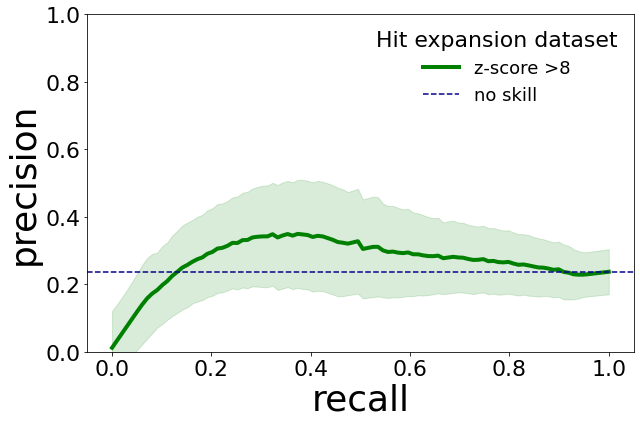

In [48]:
import matplotlib.pyplot as plt

thresh = 8
#thresh = 4.5
nbootstrap = 1000
samplesize = len(df)
x = np.linspace(0,1,100)

ps = []
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)
    samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    #yr = (df_sample['113_x']> thresh) #& (df_sample['111_112'] > thresh)
    yr = df_sample['z-score_gmean'] >= thresh
    #yr = df_sample['z-score'] >= thresh
#    p, r, _ = precision_recall_curve(yr, df_sample['proba'])
    p, r, _ = precision_recall_curve(yr, samples)
#                                        sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
#     p, r, _ = roc_curve(yr, df_sample['prediction'])
#     ps.append(np.interp(x,r,p))

    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15
fig, ax = plt.subplots()
fig.set_size_inches(9,6)

ax.plot(x,pavg,label='z-score >{}'.format(thresh),color='g',lw=4)
#ax.plot(x,pavg,label='enzymatic activity at $20 \\mathrm{{\\mu{{M}}}} < $ {:.0f} %'.format(thresh),color='g',lw=4)
ax.fill_between(x, pavg - perr, pavg + perr, color='g', alpha=alpha_err)


ax.axhline(pavg[-1],ls='--',color='darkblue',label='no skill')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=36)
ax.set_ylabel('precision',fontsize=36)
ax.set_ylim(0,1)
ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,title='Hit expansion dataset',fontsize=18)
l.get_title().set_fontsize(22)

fig.tight_layout()
#fig.savefig('affinity_pred_hit_expansion_new_pretrain.png',dpi=300)
#fig.savefig('affinity_pred_hit_expansion_new_pretrain.pdf')

**Primary screen**

In [72]:
df = pd.read_csv('/home/xvg/primary_screen_combined.csv')
df = df[(df['smiles'].notnull())]

In [73]:
primary_screen_dataset = InhibDataset(df=df, seq=mpro_seq_5r84, smiles_name='smiles')

In [74]:
y_pred=trainer.predict(primary_screen_dataset)
df['affinity_mean'] = scale(y_pred.predictions)
#df['affinity_var'] = scale_var(y_pred.predictions[:,1])

RDKit ERROR: [12:03:14] SMILES Parse Error: syntax error while parsing: CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O
RDKit ERROR: [12:03:14] SMILES Parse Error: Failed parsing SMILES 'CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O' for input: 'CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O'
[12:03:14] SMILES Parse Error: syntax error while parsing: CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O
[12:03:14] SMILES Parse Error: Failed parsing SMILES 'CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O' for input: 'CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O'


In [75]:
from scipy.stats import spearmanr

x = df['affinity_mean']
y = df['z-score']
spearmanr(x,y)

SpearmanrResult(correlation=0.013114285651576954, pvalue=0.8146571091269901)

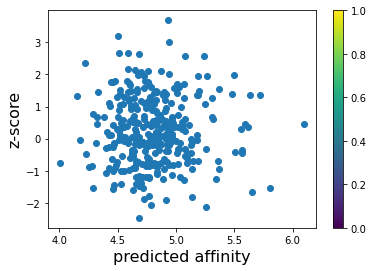

In [76]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y = df['z-score']
x = df['affinity_mean']
#z = df['affinity_var']
p = ax.scatter(x,y)#,c=z)
ax.set_xlabel('predicted affinity',fontsize=16)
ax.set_ylabel('z-score',fontsize=16)
fig.colorbar(p)

**PLpro**

In [49]:
df = pd.read_csv('/home/xvg/shen_2021_biorxiv.csv',sep=',',header=None)
df = df.rename(columns={0: 'smiles', 1: 'name', 2: 'ic50'})

In [50]:
def make_numeric(ic50): 
    try:
        return float(ic50.replace('<','').replace('>','').split('-')[-1].split('~')[-1])
    except Exception as e:
        return np.nan

In [51]:
df['pIC50'] = 6-np.log(df['ic50'].apply(make_numeric).astype('float32'))/np.log(10)

In [52]:
# Jerry?
#plpro_seq = 'VRTIKVFTTVDNINLHTQVVDMSMTYGQQFGPTYLDGADVTKIKPHNSHEGKTFYVLPNDDTLRVEAFEYYHTTDPSFLGRYMSALNHTKKWKYPQVNGLTSIKWADNNCYLATALLTLQQIELKFNPPALQDAYYRARAGEAANFCALILAYCNKTVGELGDVRETMSYLFQHANLDSCKRVLNVVCKTCGQQQTTLKGVEAVMYMGTLSYEQFKKGVQIPCTCGKQATKYLVQQESPFVMMSAPPAQYELKHGTFTCASEYTGNYQCGHYKHITSKETLYCIDGALLTKSSEYKGPITDVFYKENSYTTTI'

In [53]:
# aa 1564-1878 in https://www.uniprot.org/uniprot/P0C6X7#PRO_0000037311
plpro_seq = 'SMTYGQQFGPTYLDGADVTKIKPHVNHEGKTFFVLPSDDTLRSEAFEYYHTLDESFLGRYMSALNHTKKWKFPQVGGLTSIKWADNNCYLSSVLLALQQLEVKFNAPALQEAYYRARAGDAANFCALILAYSNKTVGELGDVRETMTHLLQHANLESAKRVLNVVCKHCGQKTTTLTGVEAVMYMGTLSYDNLKTGVSIPCVCGRDATQYLVQQESSFVMMSAPPAEYKLQQGTFLCANEYTGNYQCGHYTHITAKETLYRIDGAHLTKMSEYKGPVTDVFYKETSYTTTIKPVSYKLDGVTYTEIEPKLDGYYK'

In [54]:
#plpro_seq = df_virus.iloc[13].seq

In [55]:
shen_dataset = InhibDataset(df,seq=plpro_seq,smiles_name='smiles')

In [56]:
# y_pred=trainer.predict(shen_dataset)
# df['affinity_mean'] = scale(y_pred.predictions)
# #df['affinity_var'] = scale_var(y_pred.predictions[:,1])

In [57]:
n = len(model_files)

for i in tqdm.auto.tqdm(range(n)):
    load_ensemble(i)
    y_pred=trainer.predict(shen_dataset)
    df[f'affinity_{i}'] = scale(y_pred.predictions)
df['affinity_mean'] = np.mean([df[f'affinity_{i}'] for i in range(n)],axis=0)
df['affinity_var'] = np.var([df[f'affinity_{i}'] for i in range(n)],axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

Tokenizer lower_case: False
Tokenizer lower_case: False


RDKit ERROR: [10:28:38] SMILES Parse Error: extra open parentheses for input: 'Cc2ccc(NC1CNC1)cc2C(=O)N[C@H](C)c5cccc(c4ccc(C(=O)NC[C@H]3CCCO3)s'
[10:28:38] SMILES Parse Error: extra open parentheses for input: 'Cc2ccc(NC1CNC1)cc2C(=O)N[C@H](C)c5cccc(c4ccc(C(=O)NC[C@H]3CCCO3)s'
RDKit ERROR: [10:28:38] SMILES Parse Error: extra open parentheses for input: 'Cc2ccc(NC1CNC1)cc2C(=O)N[C@H](C)c5cccc(c4ccc(C(=O)NC[C@@H]3CCCO3)'
[10:28:38] SMILES Parse Error: extra open parentheses for input: 'Cc2ccc(NC1CNC1)cc2C(=O)N[C@H](C)c5cccc(c4ccc(C(=O)NC[C@@H]3CCCO3)'


In [58]:
# uncomment to load paper results
# tokenizer_type = 'regex'
##df.to_parquet(f'shen_{tokenizer_type}.parquet')
#df = pd.read_parquet(f'shen_{tokenizer_type}.parquet')

In [59]:
from scipy.stats import spearmanr, pearsonr

nbootstrap = 500
samplesize = len(df.dropna())

sp = []
mse = []
for i in range(nbootstrap):
    df_sample = df.dropna().sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'])
    #samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    samples = df_sample['affinity_mean']
    x = samples
    y = df_sample['pIC50']

    import pickle
    s = spearmanr(x,y)
    sp.append(s.correlation)    
    mse.append(mean_squared_error(y,x))

#pickle.dump([np.mean(sp),np.std(sp)],open(f'shen_plpro_spearmanr_{tokenizer_type}.p','wb'))
print(np.mean(sp), np.std(sp))
print(np.mean(mse), np.std(mse))

0.5842448018946025 0.08607778371656837
0.8695467113473402 0.11809877956908749


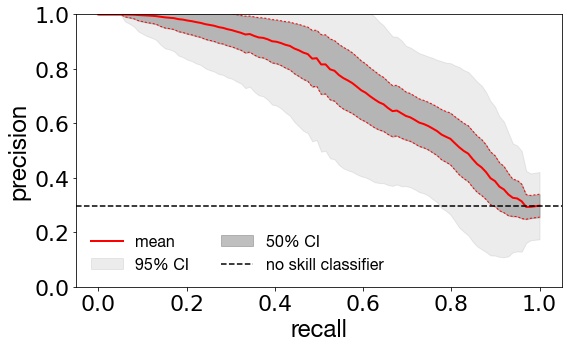

In [60]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import linregress
from scipy.constants import golden

thresh = 6
nbootstrap = 2500
samplesize = len(df)
x = np.linspace(0,1,100)

fig, ax = plt.subplots()
fig.set_size_inches(8,8/golden)
#df_select = df[np.log(df['affinity_var'])]
ps = []
np.random.seed(41)
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)#,weights=1/df['affinity_var'],seed=0)
    yr = df_sample['pIC50'] > thresh
    #samples = np.random.normal(df_sample['affinity_mean'],np.sqrt(df_sample['affinity_var']))
    p, r, _ = precision_recall_curve(yr,df_sample['affinity_mean'])#, sample_weight=1/df_sample['affinity_var'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    #if i % 100 == 0:
    #    ax.plot(r,p,'-',color='b',alpha=1,lw=.5)
    #r, p, _ = roc_curve(yr, df_sample.prediction)
    #ps.append(np.interp(x,r,p))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15

ci = 1.96
lower = pavg - ci*perr
upper = pavg + ci*perr
ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
#ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
#ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=alpha_err, label='95% CI'.format(thresh))

ci = 0.67
lower = pavg - ci*perr
upper = pavg + ci*perr
#ax.plot(x,pavg,label='mean'.format(thresh),color='r',lw=2)
ax.plot(x,lower,color='r',lw=1,dashes=[2,2])
ax.plot(x,upper,color='r',lw=1,dashes=[2,2])
ax.fill_between(x, lower, upper, color='gray', alpha=.5, label='50% CI'.format(thresh))

ax.axhline(pavg[-1],ls='--',color='black',label='no skill classifier')

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylabel('precision',fontsize=24,fontfamily='Helvetica Neue')
ax.set_ylim(0,1)

ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,fontsize=16,loc='lower left',ncol=2)
l.get_title().set_fontsize(20)
plt.setp(l.texts, family='Helvetica Neue')

# ax2 = ax.inset_axes(bounds=(0.6,0.6,0.4,0.4))
# df_select = df#[df['f_avg_IC50']<90]
# y = 6-np.log(df_select['f_avg_IC50'])/np.log(10)
# x = df_select['affinity_mean']
# c = -np.log(df_select['affinity_var'])
# ax2.scatter(x,y,c=c)
# res = linregress(x,y)
# xfit = np.linspace(x.min(),x.max(),2)
# ax2.plot(xfit,res.intercept + res.slope*xfit, 'r', label=f"{res.slope :.2f}*x+{res.intercept:.2f}")
# ax2.set_ylabel('experimental pIC50',fontsize=14)
# ax2.set_xlabel('predicted pIC50',fontsize=14)
# ax2.legend(frameon=False)
# ax2.tick_params(labelsize=16)

# df_select = df[df['f_avg_IC50'] < thresh]
# ax2.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=25,alpha=0.5,zorder=2,lw=0.5,edgecolor='k')
# df_select = df[df['f_avg_IC50'] >= thresh]
# ax2.scatter(df_select['affinity_mean'],np.log(df_select['affinity_var']),s=25,alpha=0.5,zorder=1,lw=0.5,edgecolor='k')
# ax2.set_xlabel('-log[Affinity] $\mu$',fontsize=22)
# ax2.set_ylabel('log $\sigma^2$',fontsize=22)
# ax2.axvline(6-np.log(thresh)/np.log(10),dashes=[1,1])

fig.tight_layout()
fig.savefig('plpro_new.png',dpi=300)
# fig.savefig('plpro_new_pretrain.pdf')
# fig.savefig('plpro_new_pretrain.svg')

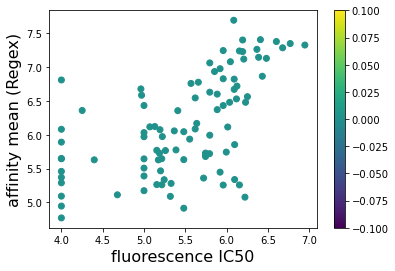

In [61]:
import matplotlib.pyplot as plt
fig, ax =plt.subplots()
field = 'pIC50'
x = df[field]
y = df['affinity_mean']
z = df['affinity_var']
ax.set_xlabel('fluorescence IC50',fontsize=16)
ax.set_ylabel('affinity mean (Regex)',fontsize=16)
p = ax.scatter(x,y,c=z)
fig.colorbar(p)